## Load and prep columns

In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


# Define columns
data_columns = ['symbol', 'quoteDate', 'adjustedPrice', 'volume', 'previousClose', 'change', 'changeInPercent', 
                '52WeekHigh', '52WeekLow', 'changeFrom52WeekHigh', 'changeFrom52WeekLow', 
                'percebtChangeFrom52WeekHigh', 'percentChangeFrom52WeekLow', 'Price200DayAverage', 
                'Price52WeekPercChange', '1WeekVolatility', '2WeekVolatility', '4WeekVolatility', '8WeekVolatility', 
                '12WeekVolatility', '26WeekVolatility','52WeekVolatility','4WeekBollingerPrediction', '4WeekBollingerType',
                '12WeekBollingerPrediction', '12WeekBollingerType', 'allordpreviousclose', 'allordchange', 
                'allorddayshigh', 'allorddayslow', 'allordpercebtChangeFrom52WeekHigh', 
                'allordpercentChangeFrom52WeekLow', 'asxpreviousclose', 'asxchange', 'asxdayshigh', 
                'asxdayslow', 'asxpercebtChangeFrom52WeekHigh', 'asxpercentChangeFrom52WeekLow', 'exDividendDate', 
                'exDividendPayout', '640106_A3597525W', 'AINTCOV', 'AverageVolume', 'BookValuePerShareYear', 
                'CashPerShareYear', 'DPSRecentYear', 'EBITDMargin', 'EPS', 'EPSGrowthRate10Years', 
                'EPSGrowthRate5Years', 'FIRMMCRT', 'FXRUSD', 'Float', 'GRCPAIAD', 'GRCPAISAD', 'GRCPBCAD', 
                'GRCPBCSAD', 'GRCPBMAD', 'GRCPNRAD', 'GRCPRCAD', 'H01_GGDPCVGDP', 'H01_GGDPCVGDPFY', 'H05_GLFSEPTPOP', 
                'IAD', 'LTDebtToEquityQuarter', 'LTDebtToEquityYear', 'MarketCap',
                'NetIncomeGrowthRate5Years', 'NetProfitMarginPercent', 'OperatingMargin', 'PE',
                'PriceToBook', 'ReturnOnAssets5Years', 'ReturnOnAssetsTTM', 'ReturnOnAssetsYear', 
                'ReturnOnEquity5Years', 'ReturnOnEquityTTM', 'ReturnOnEquityYear', 'RevenueGrowthRate10Years', 
                'RevenueGrowthRate5Years', 'TotalDebtToAssetsQuarter', 'TotalDebtToAssetsYear', 
                'TotalDebtToEquityQuarter', 'TotalDebtToEquityYear', 'bookValue', 'earningsPerShare', 
                'ebitda', 'epsEstimateCurrentYear', 'marketCapitalization', 'peRatio', 'pegRatio', 'pricePerBook', 
                'pricePerEpsEstimateCurrentYear', 'pricePerEpsEstimateNextYear', 'pricePerSales']

returns = {
    '1': 'Future1WeekReturn',
    '2': 'Future2WeekReturn',
    '4': 'Future4WeekReturn',
    '8': 'Future8WeekReturn',
    '12': 'Future12WeekReturn',
    '26': 'Future26WeekReturn',
    '52': 'Future52WeekReturn',
    '1ra': 'Future1WeekRiskAdjustedReturn',
    '2ra': 'Future2WeekRiskAdjustedReturn',
    '4ra': 'Future4WeekRiskAdjustedReturn',
    '8ra': 'Future8WeekRiskAdjustedReturn',
    '12ra': 'Future12WeekRiskAdjustedReturn',
    '26ra': 'Future26WeekRiskAdjustedReturn',
    '52ra': 'Future52WeekRiskAdjustedReturn'
}

# Load data
raw_data = pd.read_csv('data/companyQuotes-20170417-001.csv')
raw_data.head(5)

/Users/neilkloot/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/neilkloot/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,symbol,quoteDate,lastTradePriceOnly,adjustedPrice,volume,daysHigh,daysLow,previousClose,change,changeInPercent,52WeekHigh,52WeekLow,changeFrom52WeekHigh,changeFrom52WeekLow,percebtChangeFrom52WeekHigh,percentChangeFrom52WeekLow,Price200DayAverage,Price52WeekPercChange,1WeekVolatility,2WeekVolatility,4WeekVolatility,8WeekVolatility,12WeekVolatility,26WeekVolatility,52WeekVolatility,4WeekBollingerBandLower,4WeekBollingerBandUpper,4WeekBollingerPrediction,4WeekBollingerType,12WeekBollingerBandLower,12WeekBollingerBandUpper,12WeekBollingerPrediction,12WeekBollingerType,allordpreviousclose,allordchange,allorddayshigh,allorddayslow,allordpercebtChangeFrom52WeekHigh,allordpercentChangeFrom52WeekLow,asxpreviousclose,asxchange,asxdayshigh,asxdayslow,asxpercebtChangeFrom52WeekHigh,asxpercentChangeFrom52WeekLow,exDividendDate,exDividendPayout,640106_A3597525W,AINTCOV,AverageVolume,Beta,BookValuePerShareYear,CashPerShareYear,DPSRecentYear,EBITDMargin,EPS,EPSGrowthRate10Years,EPSGrowthRate5Years,FIRMMCRT,FXRUSD,Float,GRCPAIAD,GRCPAISAD,GRCPBCAD,GRCPBCSAD,GRCPBMAD,GRCPNRAD,GRCPRCAD,H01_GGDPCVGDP,H01_GGDPCVGDPFY,H05_GLFSEPTPOP,IAD,LTDebtToEquityQuarter,LTDebtToEquityYear,MarketCap,NetIncomeGrowthRate5Years,NetProfitMarginPercent,OperatingMargin,PE,PriceToBook,QuoteLast,ReturnOnAssets5Years,ReturnOnAssetsTTM,ReturnOnAssetsYear,ReturnOnEquity5Years,ReturnOnEquityTTM,ReturnOnEquityYear,RevenueGrowthRate10Years,RevenueGrowthRate5Years,TotalDebtToAssetsQuarter,TotalDebtToAssetsYear,TotalDebtToEquityQuarter,TotalDebtToEquityYear,bookValue,earningsPerShare,ebitda,epsEstimateCurrentYear,marketCapitalization,peRatio,pegRatio,pricePerBook,pricePerEpsEstimateCurrentYear,pricePerEpsEstimateNextYear,pricePerSales,Future1WeekDividend,Future1WeekPrice,Future1WeekReturn,Future1WeekRiskAdjustedReturn,Future2WeekDividend,Future2WeekPrice,Future2WeekReturn,Future2WeekRiskAdjustedReturn,Future4WeekDividend,Future4WeekPrice,Future4WeekReturn,Future4WeekRiskAdjustedReturn,Future8WeekDividend,Future8WeekPrice,Future8WeekReturn,Future8WeekRiskAdjustedReturn,Future12WeekDividend,Future12WeekPrice,Future12WeekReturn,Future12WeekRiskAdjustedReturn,Future26WeekDividend,Future26WeekPrice,Future26WeekReturn,Future26WeekRiskAdjustedReturn,Future52WeekDividend,Future52WeekPrice,Future52WeekReturn,Future52WeekRiskAdjustedReturn
0,CCA,2016-06-30,0.560,0.560,1876700,0.770,0.535,0.765,-0.205,-0.267974,0.56,0.560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.560000,0.560000,Steady,Within,0.560000,0.560000,Steady,Within,5221.000000,41.299805,5324.399902,5221.000000,-0.082183,0.083960,5142.399902,39.100097,5247.600098,5142.399902,-0.098884,0.079135,NaN,NaN,108.2,3828.0,NaN,NaN,0.24,-0.213,NaN,NaN,-30.8,NaN,NaN,1.77,0.7426,63500000.0,87.307409,89.957900,87.425456,92.706255,87.037799,85.756318,96.070719,412937.0,1.227102,61.092677,NaN,NaN,NaN,36000000.0,NaN,NaN,-4147.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-67.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55,-1.785714,-7.688946,NaN,0.65,16.071429,2.693578,NaN,0.64,14.285714,2.260607,NaN,0.61,8.928571,1.801456,NaN,0.54,-3.571429,-19.327464,NaN,0.56,NaN,NaN,NaN,NaN,NaN,NaN
1,CCA,2016-07-01,0.590,0.590,985000,0.625,0.500,0.515,0.075,0.145631,0.59,0.560,0.000,0.03,0.000000,0.053571,NaN,NaN,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.545000,0.605000,Steady,Within,0.545000,0.605000,Steady,Within,5310.399902,89.399902,5356.500000,5310.399902,-0.066467,0.102520,5233.399902,91.000000,5278.899902,5233.399902,-0.082938,0.098231,NaN,NaN,108.2,3828.0,NaN,NaN,0.24,-0.213,0.0,NaN,-30.8,NaN,NaN,1.77,0.7460,63500000.0,87.307409,89.957900,87.425456,92.706255,87.037799,85.756318,96.070719,412937.0,1.227102,61.092677,NaN,NaN,NaN,36000000.0,NaN,NaN,-4147.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-67.4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.54,-8.474576,-33.621753,0.0,0.65,10.169492,1.644524,0.0,0.67,13.559322,2.167481,0.0,0.60,1.694915,0.343165,0.0,0.52,-11.864407,-65.4875

In [39]:
# Clip values less than -99 (represents losing all money, can't go below -100)
for key in returns:
    return_column = returns[key]
    raw_data[return_column] = raw_data[return_column].clip(-99, 999, axis=0)

-----
Future1WeekReturn


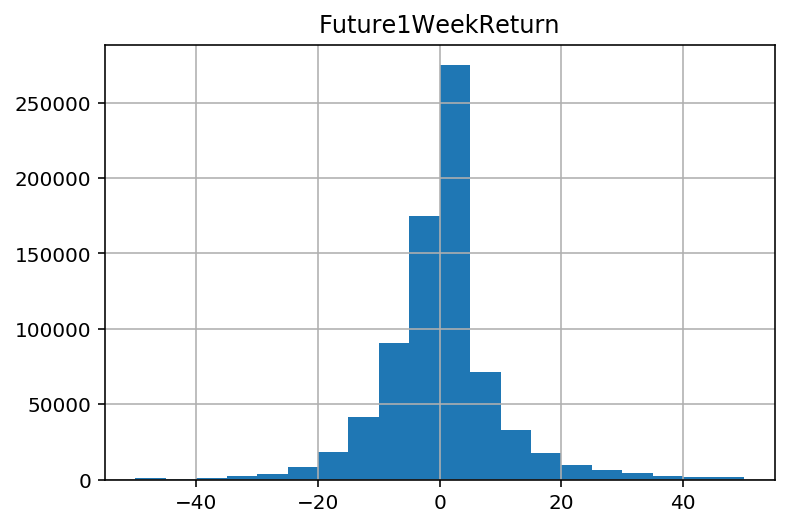

Instances:  771258
Mean:  0.66749349929423
Min:  -99.0
25th percentile:  -4.166477525538371
Median:  0.0
75th percentile:  3.532008830022078
Max:  999.0
Std deviation:  17.143212329362083
Variance:  293.88972896959217
Skew:  26.6957743473
-----
Future2WeekReturn


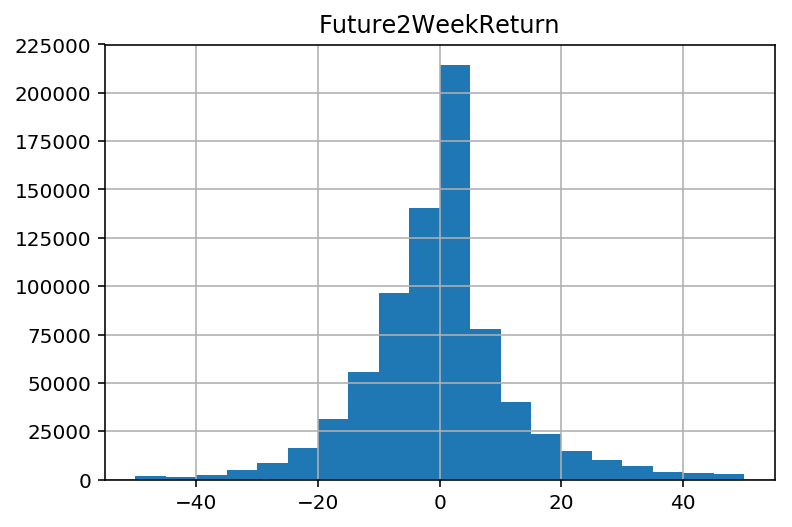

Instances:  768178
Mean:  0.9908452841230754
Min:  -99.0
25th percentile:  -6.245232613447025
Median:  0.0
75th percentile:  5.041693008332588
Max:  999.0
Std deviation:  22.76641118893877
Variance:  518.3094784238364
Skew:  19.9700132019
-----
Future4WeekReturn


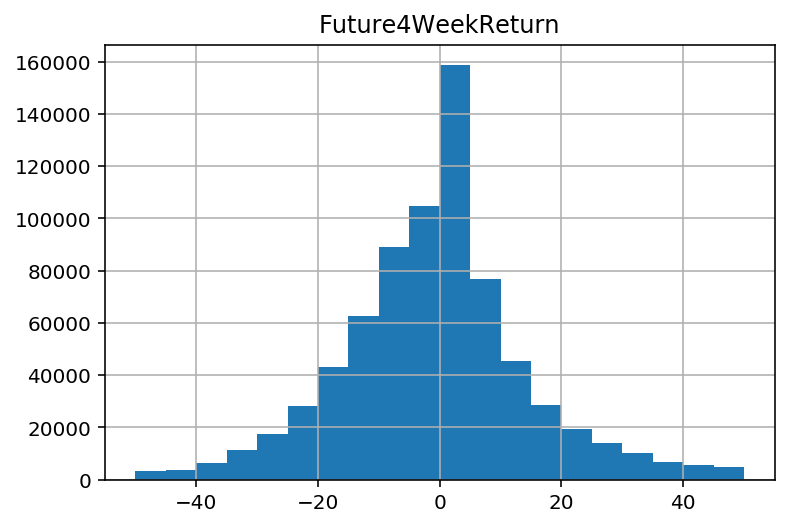

Instances:  763906
Mean:  1.48161097575045
Min:  -99.0
25th percentile:  -9.22506201958628
Median:  0.0
75th percentile:  7.331410031814271
Max:  999.0
Std deviation:  29.965677267372044
Variance:  897.9418140922976
Skew:  13.9141884111
-----
Future8WeekReturn


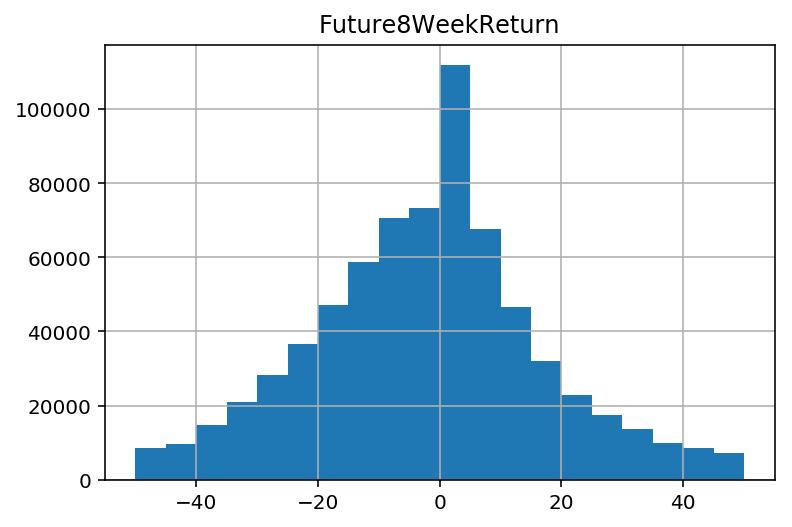

Instances:  756392
Mean:  2.292158703509559
Min:  -99.0
25th percentile:  -14.000238270449735
Median:  -0.3624301395888254
75th percentile:  10.684926885952233
Max:  999.0
Std deviation:  39.32402946234281
Variance:  1546.379293155205
Skew:  9.42624532169
-----
Future12WeekReturn


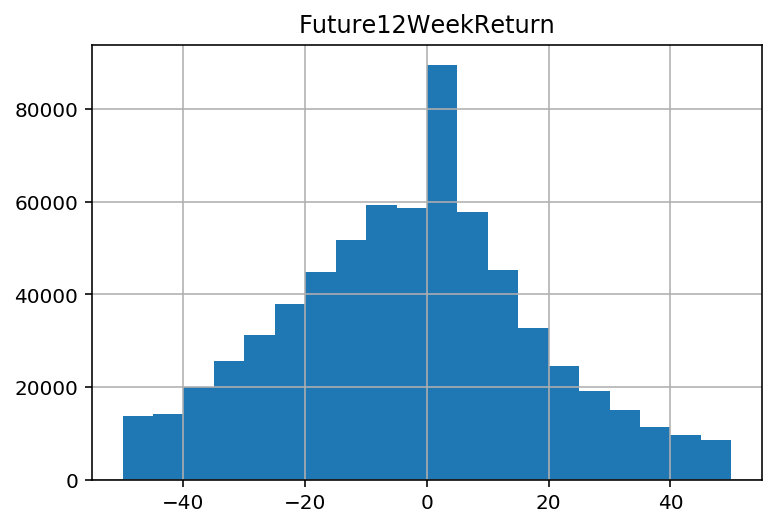

Instances:  747849
Mean:  3.0265144763760254
Min:  -99.0
25th percentile:  -17.72727272727273
Median:  -0.9523809523809532
75th percentile:  13.380335005204895
Max:  999.0
Std deviation:  46.28697830736292
Variance:  2142.4843608262854
Skew:  7.19138245771
-----
Future26WeekReturn


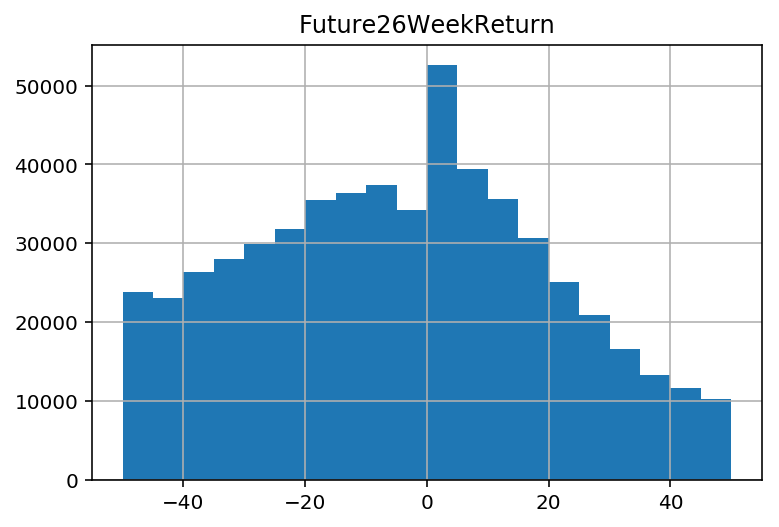

Instances:  719078
Mean:  5.366842002080248
Min:  -99.0
25th percentile:  -29.09090909090909
Median:  -3.124999999999991
75th percentile:  20.138132463997856
Max:  999.0
Std deviation:  68.57076597030942
Variance:  4701.9499457549455
Skew:  5.25751977744
-----
Future52WeekReturn


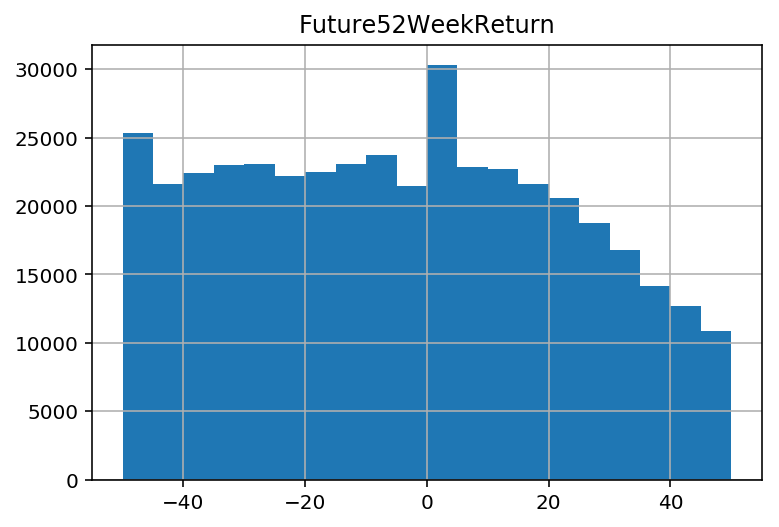

Instances:  673719
Mean:  9.30580732971579
Min:  -99.0
25th percentile:  -44.92753623188405
Median:  -7.6923076923076845
75th percentile:  29.25812356979406
Max:  999.0
Std deviation:  100.14069539348887
Variance:  10028.158873891523
Skew:  4.46897525881
-----
Future1WeekRiskAdjustedReturn


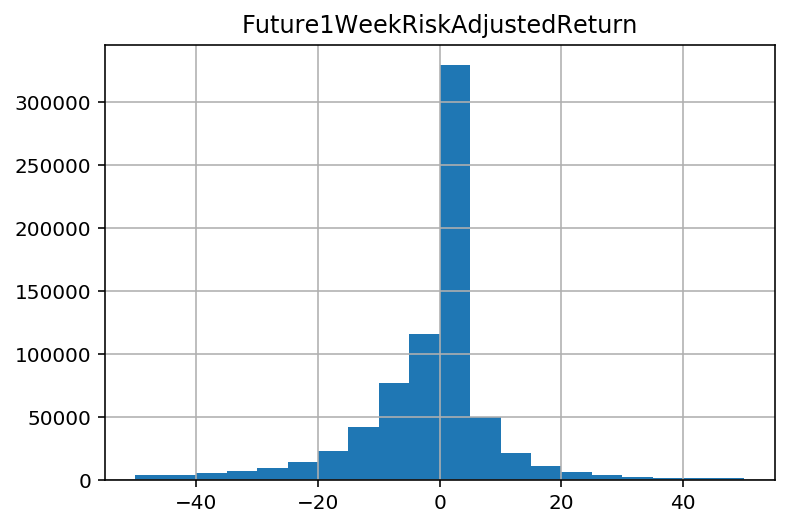

Instances:  771258
Mean:  -6.356286552246023
Min:  -99.0
25th percentile:  -6.832447236429337
Median:  0.0
75th percentile:  1.451068071072563
Max:  999.0
Std deviation:  23.64828663589008
Variance:  559.2414608132174
Skew:  0.422716234648
-----
Future2WeekRiskAdjustedReturn


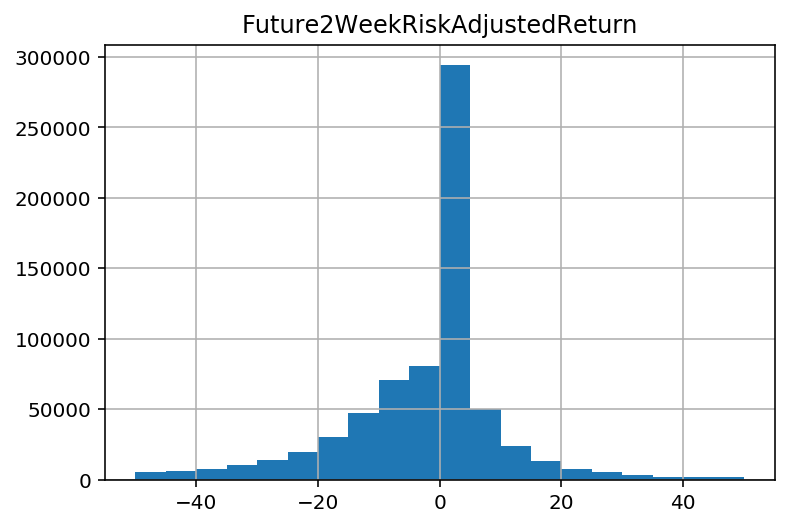

Instances:  768178
Mean:  -9.833603484757546
Min:  -99.0
25th percentile:  -11.538461538461537
Median:  0.0
75th percentile:  1.707451387294313
Max:  999.0
Std deviation:  29.733549304018226
Variance:  884.0839542144827
Skew:  0.715440853771
-----
Future4WeekRiskAdjustedReturn


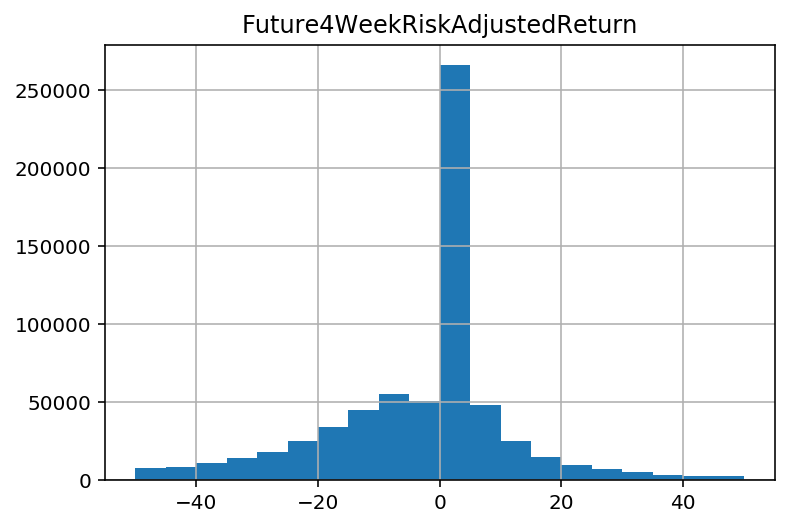

Instances:  763906
Mean:  -14.318319927549718
Min:  -99.0
25th percentile:  -20.0
Median:  0.0
75th percentile:  1.9156917902369668
Max:  999.0
Std deviation:  36.3192415410265
Variance:  1319.087306115425
Skew:  0.83701298295
-----
Future8WeekRiskAdjustedReturn


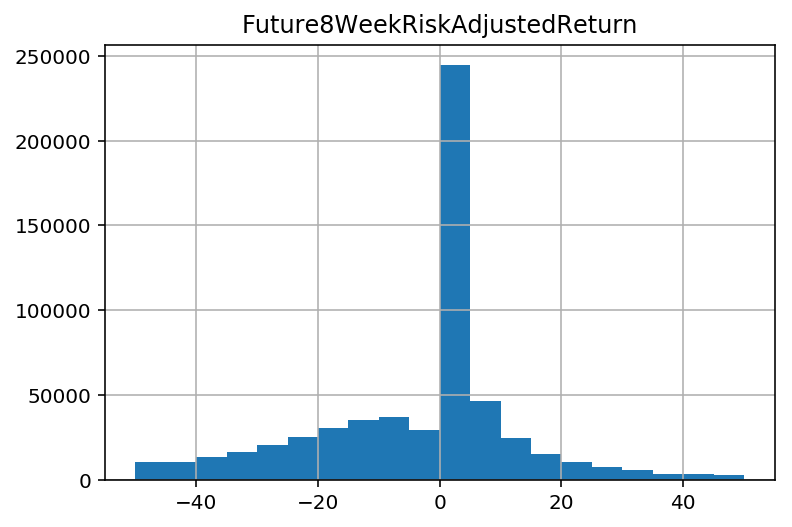

Instances:  756392
Mean:  -19.535226677119024
Min:  -99.0
25th percentile:  -34.436030290952566
Median:  -1.1325528539414425
75th percentile:  2.0855848055549266
Max:  999.0
Std deviation:  43.138599082731545
Variance:  1860.9387308206472
Skew:  1.08294835721
-----
Future12WeekRiskAdjustedReturn


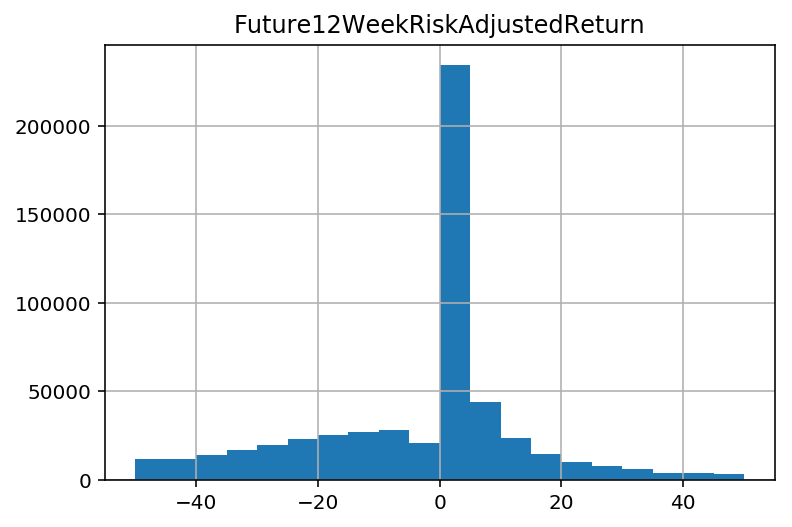

Instances:  747849
Mean:  -22.86078494493137
Min:  -99.0
25th percentile:  -49.71318323553252
Median:  -2.631578947368428
75th percentile:  2.1381167989637078
Max:  999.0
Std deviation:  46.979652356297244
Variance:  2207.0877355185453
Skew:  1.12730115201
-----
Future26WeekRiskAdjustedReturn


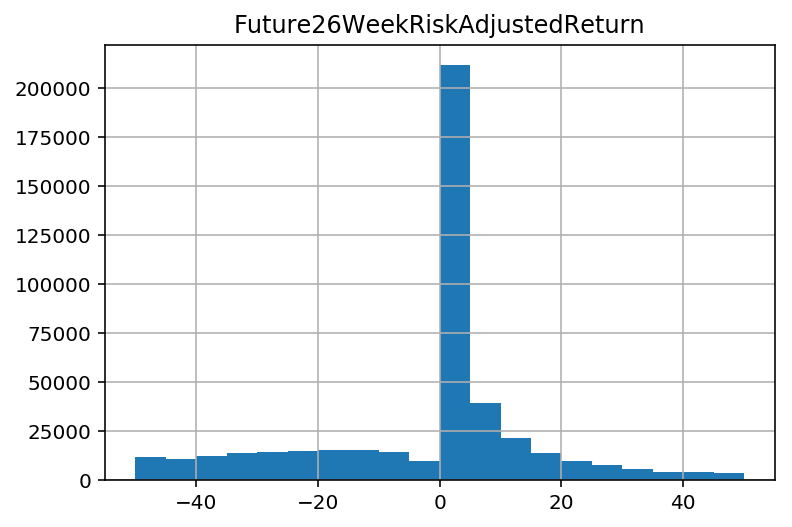

Instances:  719078
Mean:  -30.16362656968548
Min:  -99.0
25th percentile:  -99.0
Median:  -8.602150537634401
75th percentile:  2.117613272331397
Max:  999.0
Std deviation:  55.325118401630846
Variance:  3060.868726154472
Skew:  1.92316300251
-----
Future52WeekRiskAdjustedReturn


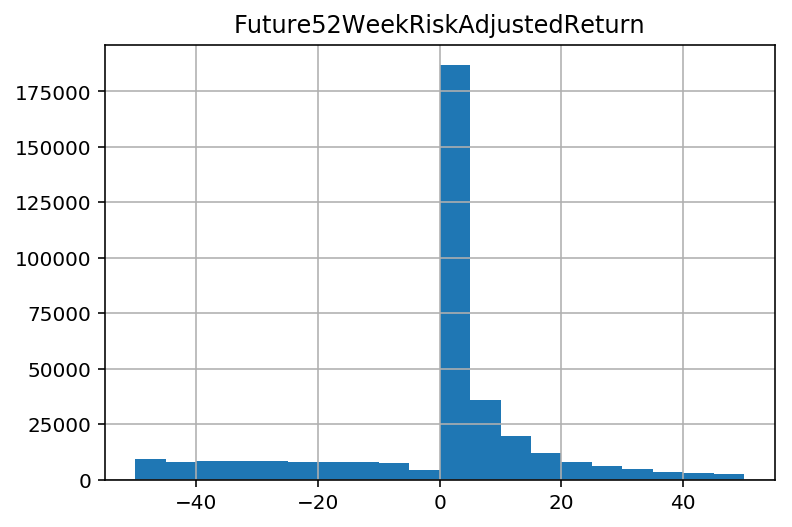

Instances:  673719
Mean:  -36.83505852019241
Min:  -99.0
25th percentile:  -99.0
Median:  -24.137507452679205
75th percentile:  1.8969033890460054
Max:  999.0
Std deviation:  62.46447724303616
Variance:  3901.810917245782
Skew:  3.15166827602


In [40]:
# Plot values for each potential target
for key in returns:
    print('-----')
    return_column = returns[key]
    print(return_column)
    raw_data.hist(column=return_column,bins=[-50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 
                                            5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    pyplot.show()


    print('Instances: ', raw_data[return_column].count())
    print('Mean: ', raw_data[return_column].mean())
    print('Min: ', raw_data[return_column].min())
    print('25th percentile: ', raw_data[return_column].quantile(0.25))
    print('Median: ', raw_data[return_column].median())
    print('75th percentile: ', raw_data[return_column].quantile(0.75))
    print('Max: ', raw_data[return_column].max())
    print('Std deviation: ', raw_data[return_column].std())
    print('Variance: ', raw_data[return_column].var())
    print('Skew: ', raw_data[return_column].skew())

In [23]:
# Set-up data buckets
#base_buckets = np.array([3.0, 6.0, 12.5, 25.0, 50.0, 100.0])
base_buckets = np.array([5.0, 10.0, 20, 50, 100, 500])

buckets_1 = base_buckets / 52 * 1
#buckets_1 = buckets_1 + (0.10 * 52 / 1)

buckets_2 = base_buckets / 52 * 2
#buckets_2 = buckets_2 + (0.10 * 52 / 2)

buckets_4 = base_buckets / 52 * 4
#buckets_4 = buckets_4 + (0.10 * 52 / 4)

buckets_8 = base_buckets / 52 * 8
#buckets_8 = buckets_8 + (0.10 * 52 / 8)

buckets_12 = base_buckets / 52 * 12
#buckets_12 = buckets_12 + (0.10 * 52 / 12)

buckets_26 = base_buckets / 52 * 26
#buckets_26 = buckets_26 + (0.10 * 52 / 26)

buckets_52 = base_buckets


buckets = {
    '1': buckets_1,
    '2': buckets_2,
    '4': buckets_4,
    '8': buckets_8,
    '12': buckets_12,
    '26': buckets_26,
    '52': buckets_52,
    '1ra': buckets_1,
    '2ra': buckets_2,
    '4ra': buckets_4,
    '8ra': buckets_8,
    '12ra': buckets_12,
    '26ra': buckets_26,
    '52ra': buckets_52,
}

for bucket in buckets:
    buckets[bucket] = np.insert(buckets[bucket], 0, [-99, -25.0, -12.5, 0.0])
    buckets[bucket] = np.append(buckets[bucket], 99999999)
    print(bucket)
    print(buckets[bucket])

1
[ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   9.61538462e-02   1.92307692e-01   3.84615385e-01   9.61538462e-01
   1.92307692e+00   9.61538462e+00   9.99999990e+07]
2
[ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   1.92307692e-01   3.84615385e-01   7.69230769e-01   1.92307692e+00
   3.84615385e+00   1.92307692e+01   9.99999990e+07]
4
[ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   3.84615385e-01   7.69230769e-01   1.53846154e+00   3.84615385e+00
   7.69230769e+00   3.84615385e+01   9.99999990e+07]
8
[ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   7.69230769e-01   1.53846154e+00   3.07692308e+00   7.69230769e+00
   1.53846154e+01   7.69230769e+01   9.99999990e+07]
12
[ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   1.15384615e+00   2.30769231e+00   4.61538462e+00   1.15384615e+01
   2.30769231e+01   1.15384615e+02   9.99999990e+07]
26
[ -9.90000000e+01  -2.50000000e

## All data

In [ ]:
filtered_data = raw_data

## Apply filter for specific symbol

In [24]:
# Run filter for a few companies
include_symbols = ['BHP', 'CBA', 'AOU', 'AYS', 'ATT']
reduced_data = raw_data[raw_data['symbol'].isin(include_symbols)]
print(len(reduced_data))

5820


In [25]:
filtered_data = reduced_data

## Bucketise data

In [26]:
# Add cateogry values to data frames
group_names = ['Huge loss', 'Serious loss', 'Loss', 'Poor', 'Marginal', 'Average', 'Good', 'Excellent', 'Risky gain',
              'Off the charts gain']

#ret_data = raw_data[['Future1WeekReturn', 'Future2WeekReturn', 'Future4WeekReturn', 'Future8WeekReturn', 
#                    'Future12WeekReturn', 'Future26WeekReturn', 'Future52WeekReturn', 
#                    'Future1WeekRiskAdjustedReturn', 'Future2WeekRiskAdjustedReturn',
#                    'Future4WeekRiskAdjustedReturn', 'Future8WeekRiskAdjustedReturn',
#                    'Future12WeekRiskAdjustedReturn', 'Future26WeekRiskAdjustedReturn',
#                    'Future52WeekRiskAdjustedReturn']]

for key in returns:
    print('-----')
    return_column = returns[key]
    new_column = 'Cat' + return_column
    bins = buckets[key] 
    # bins = buckets['52'] 
    print('Creating', new_column, 'with bins:', bins)
    filtered_data[new_column] = pd.cut(filtered_data[return_column], bins=bins, labels=group_names, include_lowest=True)
    print('New col added')

filtered_data.head(20)

-----
Creating CatFuture1WeekReturn with bins: [ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   9.61538462e-02   1.92307692e-01   3.84615385e-01   9.61538462e-01
   1.92307692e+00   9.61538462e+00   9.99999990e+07]
New col added
-----
Creating CatFuture2WeekReturn with bins: [ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   1.92307692e-01   3.84615385e-01   7.69230769e-01   1.92307692e+00
   3.84615385e+00   1.92307692e+01   9.99999990e+07]
New col added
-----
Creating CatFuture4WeekReturn with bins: [ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   3.84615385e-01   7.69230769e-01   1.53846154e+00   3.84615385e+00
   7.69230769e+00   3.84615385e+01   9.99999990e+07]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


New col added
-----
Creating CatFuture8WeekReturn with bins: [ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   7.69230769e-01   1.53846154e+00   3.07692308e+00   7.69230769e+00
   1.53846154e+01   7.69230769e+01   9.99999990e+07]
New col added
-----
Creating CatFuture12WeekReturn with bins: [ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   1.15384615e+00   2.30769231e+00   4.61538462e+00   1.15384615e+01
   2.30769231e+01   1.15384615e+02   9.99999990e+07]
New col added
-----
Creating CatFuture26WeekReturn with bins: [ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   2.50000000e+00   5.00000000e+00   1.00000000e+01   2.50000000e+01
   5.00000000e+01   2.50000000e+02   9.99999990e+07]
New col added
-----
Creating CatFuture52WeekReturn with bins: [ -9.90000000e+01  -2.50000000e+01  -1.25000000e+01   0.00000000e+00
   5.00000000e+00   1.00000000e+01   2.00000000e+01   5.00000000e+01
   1.00000000e+02   5.00000000e+02   9.999

,symbol,quoteDate,lastTradePriceOnly,adjustedPrice,volume,daysHigh,daysLow,previousClose,change,changeInPercent,52WeekHigh,52WeekLow,changeFrom52WeekHigh,changeFrom52WeekLow,percebtChangeFrom52WeekHigh,percentChangeFrom52WeekLow,Price200DayAverage,Price52WeekPercChange,1WeekVolatility,2WeekVolatility,4WeekVolatility,8WeekVolatility,12WeekVolatility,26WeekVolatility,52WeekVolatility,4WeekBollingerBandLower,4WeekBollingerBandUpper,4WeekBollingerPrediction,4WeekBollingerType,12WeekBollingerBandLower,12WeekBollingerBandUpper,12WeekBollingerPrediction,12WeekBollingerType,allordpreviousclose,allordchange,allorddayshigh,allorddayslow,allordpercebtChangeFrom52WeekHigh,allordpercentChangeFrom52WeekLow,asxpreviousclose,asxchange,asxdayshigh,asxdayslow,asxpercebtChangeFrom52WeekHigh,asxpercentChangeFrom52WeekLow,exDividendDate,exDividendPayout,640106_A3597525W,AINTCOV,AverageVolume,Beta,BookValuePerShareYear,CashPerShareYear,DPSRecentYear,EBITDMargin,EPS,EPSGrowthRate10Years,EPSGrowthRate5Years,FIRMMCRT,FXRUSD,Float,GRCPAIAD,GRCPAISAD,GRCPBCAD,GRCPBCSAD,GRCPBMAD,GRCPNRAD,GRCPRCAD,H01_GGDPCVGDP,H01_GGDPCVGDPFY,H05_GLFSEPTPOP,IAD,LTDebtToEquityQuarter,LTDebtToEquityYear,MarketCap,NetIncomeGrowthRate5Years,NetProfitMarginPercent,OperatingMargin,PE,PriceToBook,QuoteLast,ReturnOnAssets5Years,ReturnOnAssetsTTM,ReturnOnAssetsYear,ReturnOnEquity5Years,ReturnOnEquityTTM,ReturnOnEquityYear,RevenueGrowthRate10Years,RevenueGrowthRate5Years,TotalDebtToAssetsQuarter,TotalDebtToAssetsYear,TotalDebtToEquityQuarter,TotalDebtToEquityYear,bookValue,earningsPerShare,ebitda,epsEstimateCurrentYear,marketCapitalization,peRatio,pegRatio,pricePerBook,pricePerEpsEstimateCurrentYear,pricePerEpsEstimateNextYear,pricePerSales,Future1WeekDividend,Future1WeekPrice,Future1WeekReturn,Future1WeekRiskAdjustedReturn,Future2WeekDividend,Future2WeekPrice,Future2WeekReturn,Future2WeekRiskAdjustedReturn,Future4WeekDividend,Future4WeekPrice,Future4WeekReturn,Future4WeekRiskAdjustedReturn,Future8WeekDividend,Future8WeekPrice,Future8WeekReturn,Future8WeekRiskAdjustedReturn,Future12WeekDividend,Future12WeekPrice,Future12WeekReturn,Future12WeekRiskAdjustedReturn,Future26WeekDividend,Future26WeekPrice,Future26WeekReturn,Future26WeekRiskAdjustedReturn,Future52WeekDividend,Future52WeekPrice,Future52WeekReturn,Future52WeekRiskAdjustedReturn,CatFuture1WeekReturn,CatFuture2WeekReturn,CatFuture4WeekReturn,CatFuture8WeekReturn,CatFuture12WeekReturn,CatFuture26WeekReturn,CatFuture52WeekReturn,CatFuture1WeekRiskAdjustedReturn,CatFuture2WeekRiskAdjustedReturn,CatFuture4WeekRiskAdjustedReturn,CatFuture8WeekRiskAdjustedReturn,CatFuture12WeekRiskAdjustedReturn,CatFuture26WeekRiskAdjustedReturn,CatFuture52WeekRiskAdjustedReturn
3366,AOU,2011-09-01,0.25,0.25,49800,0.25,0.225,0.225,0.025,0.111111,0.25,0.25,0.00,0.00,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,Steady,Within,0.250000,0.250000,Steady,Within,4371.600098,29.800293,4425.399902,4371.600098,-0.135347,0.087003,4297.899902,28.699707,4354.600098,4297.899902,-0.133680,0.088407,NaN,NaN,99.2,-7.67,NaN,NaN,0.11,-0.017,0.0,NaN,-3.6,NaN,NaN,4.75,1.0703,76800000.0,147.426551,147.870828,194.596925,195.269453,107.867604,157.294457,94.254111,361380.0,0.551118,62.051332,NaN,NaN,NaN,10000000.0,NaN,NaN,-551.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-39.9,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.26,4.000000,2.121320,0.0,0.26,4.000000,1.950852,0.0,0.25,0.000000,0.000000,NaN,NaN,NaN,NaN,0.0,0.280,12.000000,7.604691,0.0,0.30,20.000000,9.805826,0.0,0.360,44.000000,18.422723,Risky gain,Risky gain,Loss,NaN,Excellent,Good,Good,Risky gain,Excellent,Loss,NaN,Good,Average,Average
3367,AOU,2011-09-02,0.30,0.30,30200,0.30,0.250,0.250,0.050,0.200000,0.30,0.25,0.00,0.05,0.000000,0.200000,NaN,NaN,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.225000,0.325000,Steady,Within,0.225000,0.325000,Steady,Within,4371.299805,-0.300293,4371.299805,4305.500000,-0.135406,0.086928

Future1WeekReturn


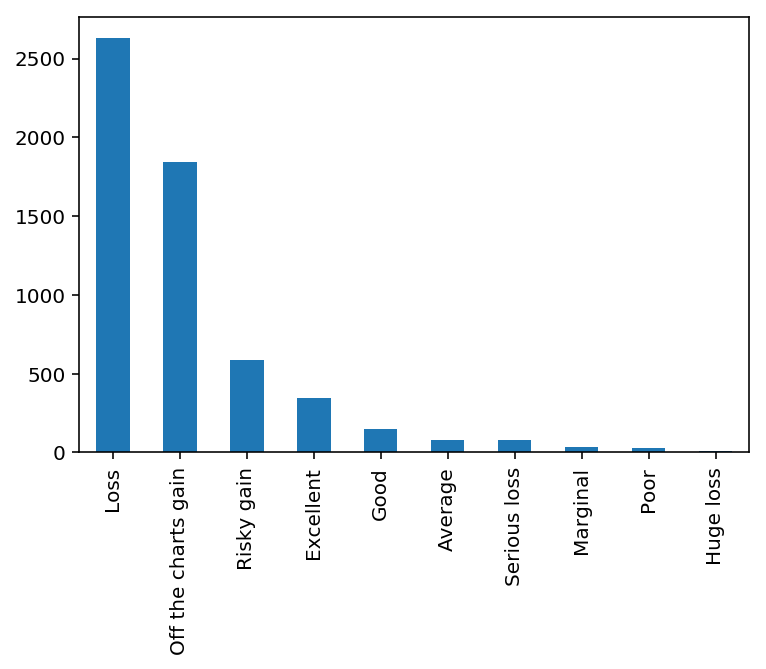

Future2WeekReturn


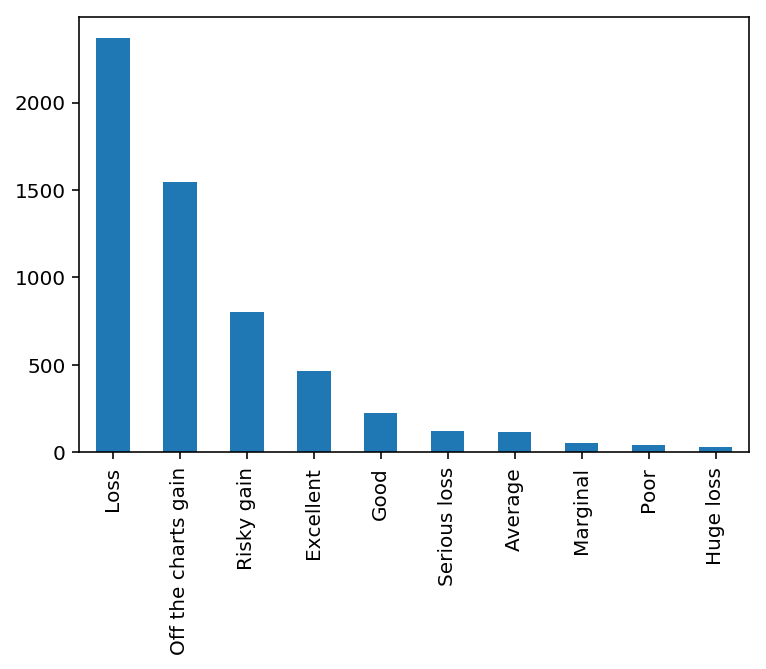

Future4WeekReturn


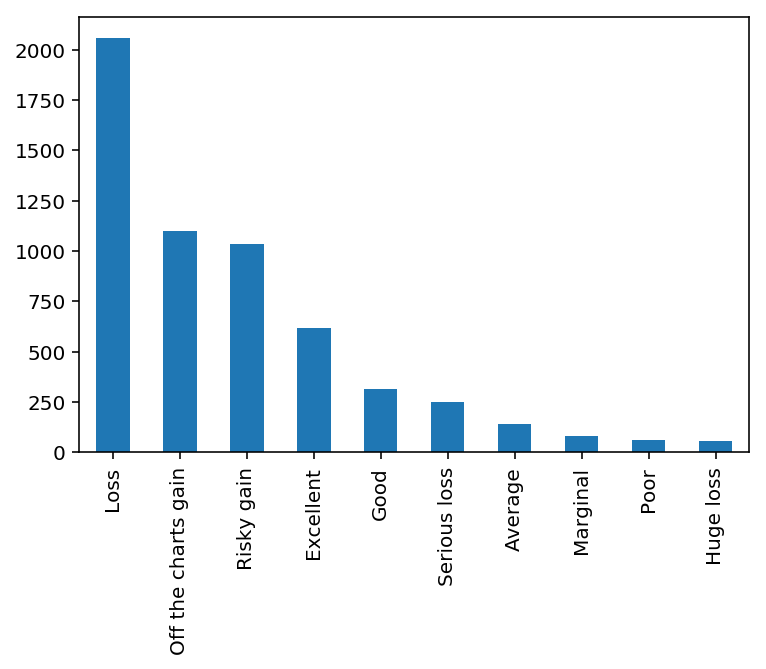

Future8WeekReturn


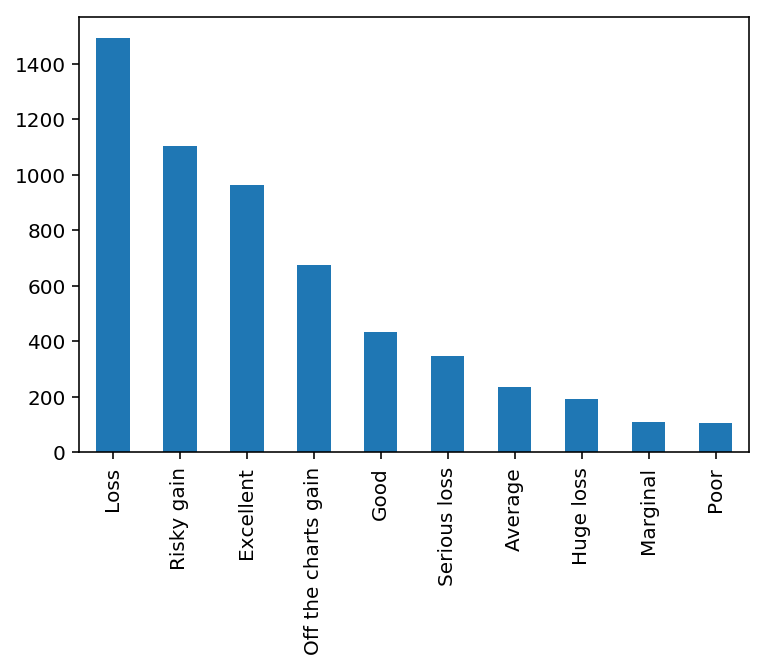

Future12WeekReturn


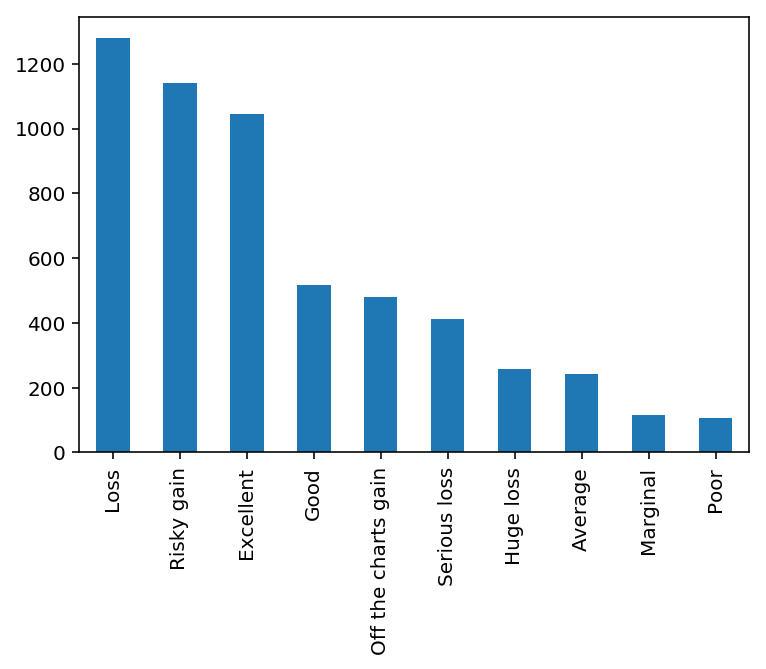

Future26WeekReturn


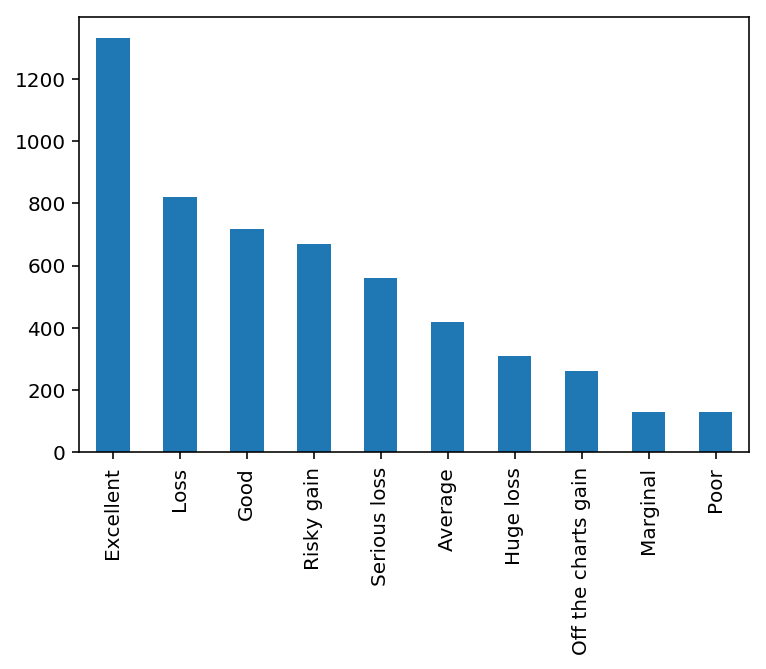

Future52WeekReturn


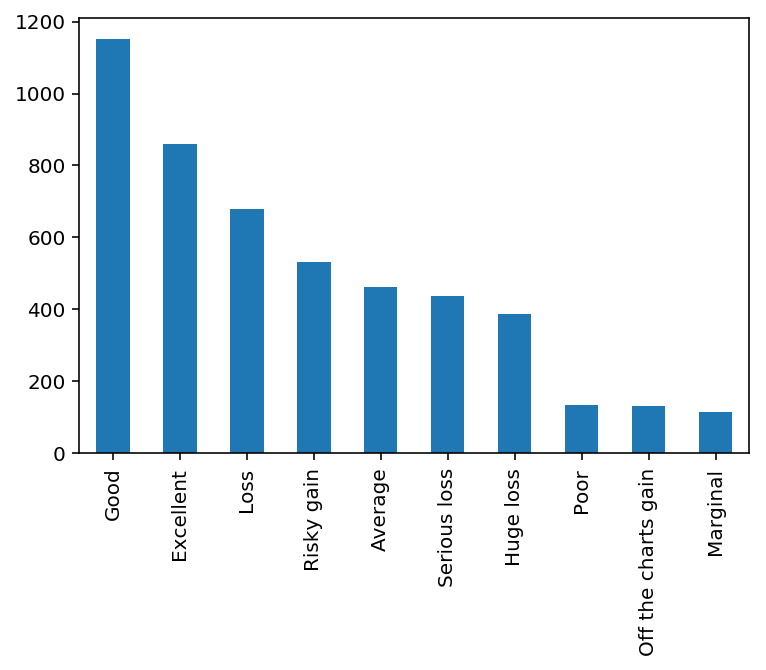

Future1WeekRiskAdjustedReturn


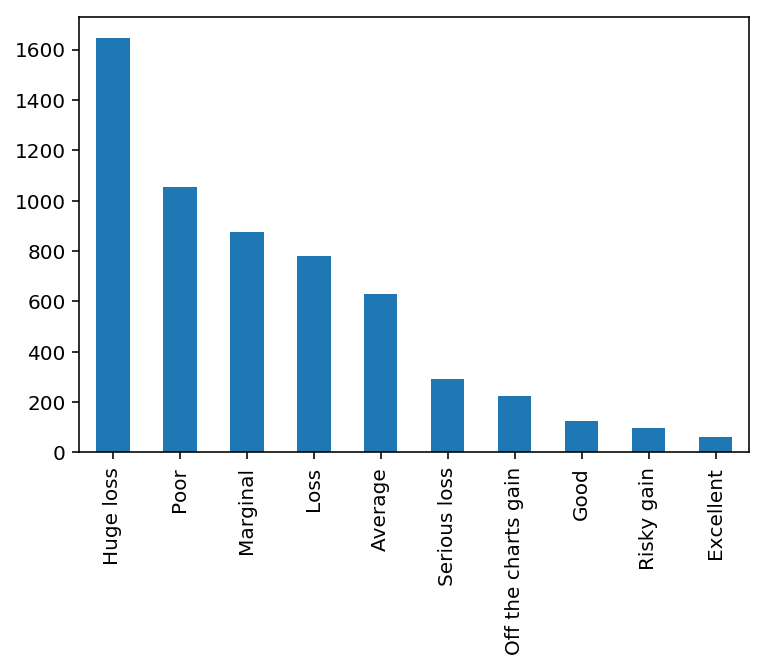

Future2WeekRiskAdjustedReturn


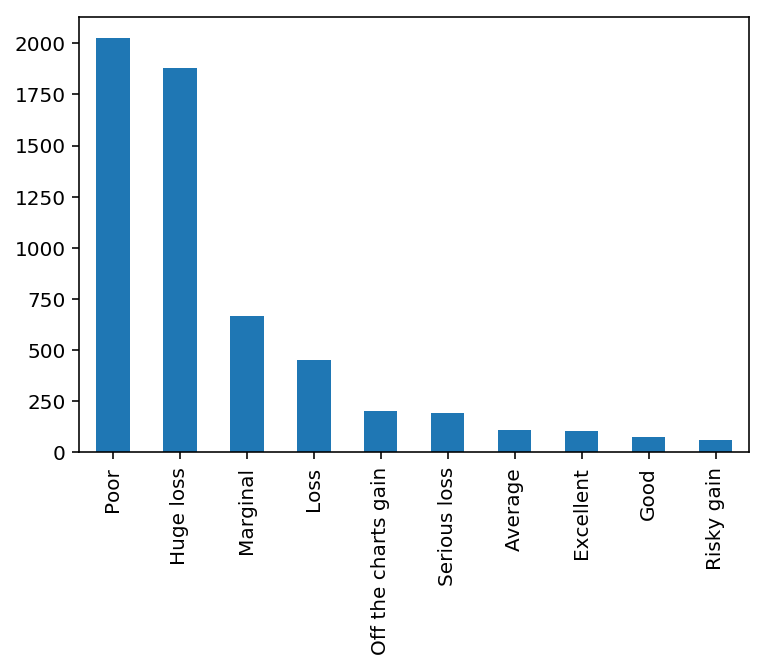

Future4WeekRiskAdjustedReturn


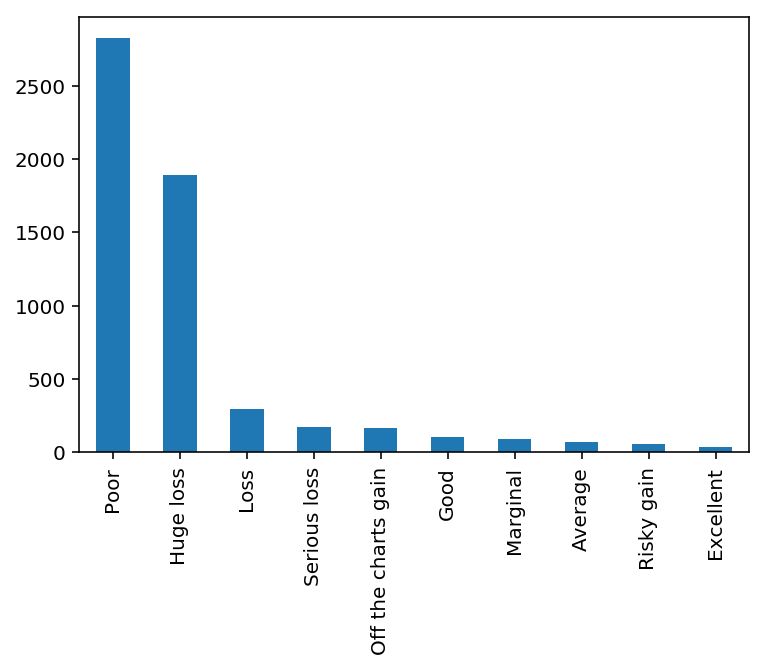

Future8WeekRiskAdjustedReturn


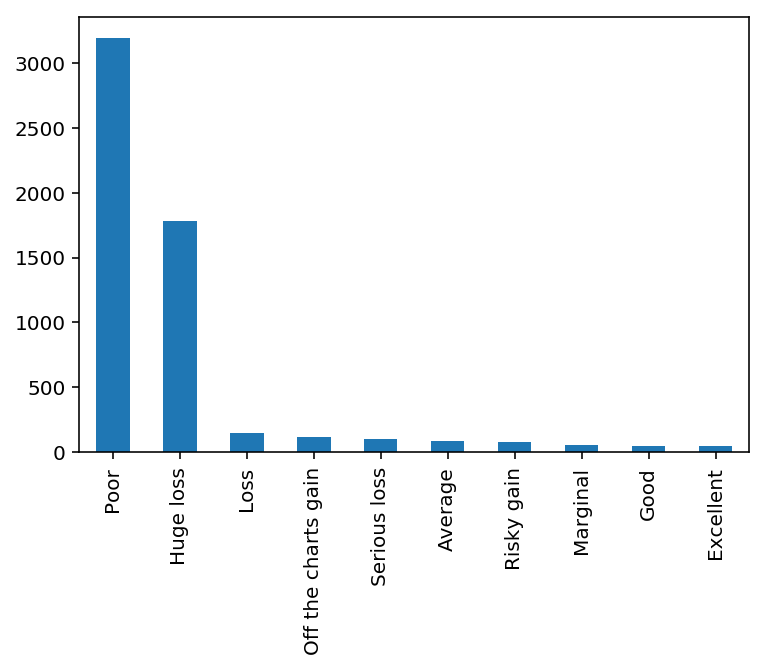

Future12WeekRiskAdjustedReturn


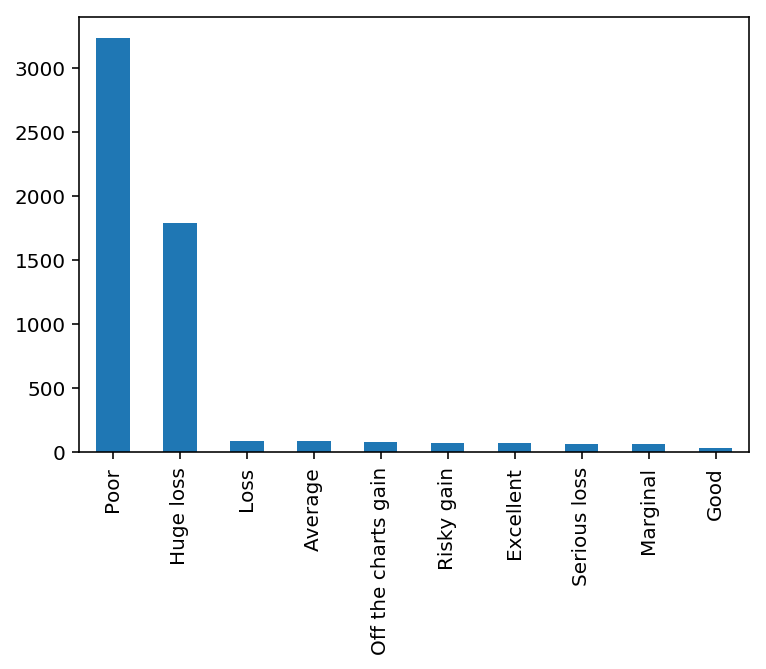

Future26WeekRiskAdjustedReturn


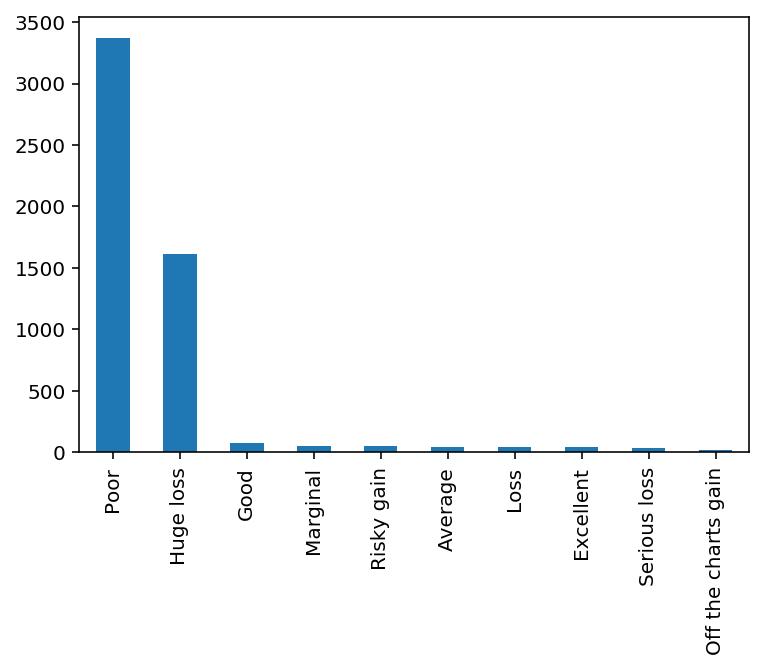

Future52WeekRiskAdjustedReturn


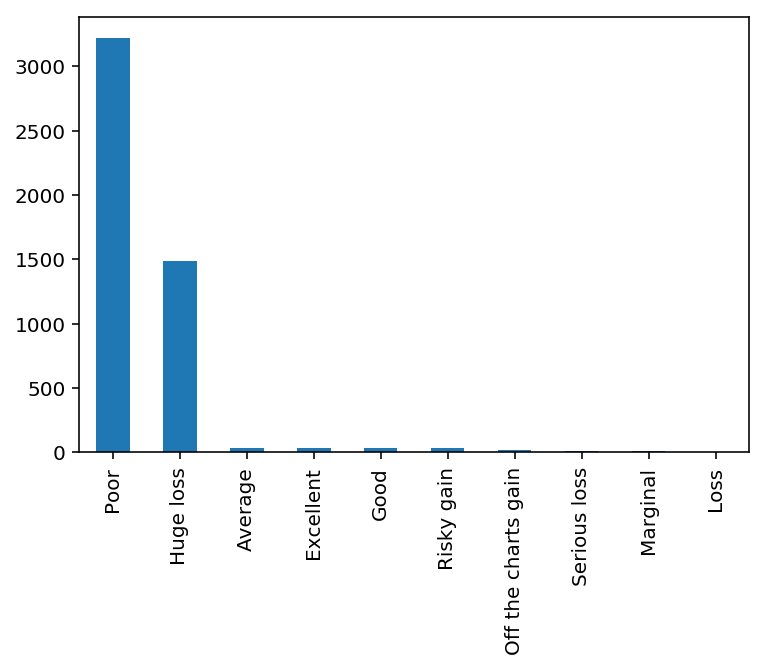

In [20]:
# Plot values in categories
for key in returns:
    print(returns[key])
    return_column = returns[key]
    new_column = 'Cat' + return_column
    filtered_data[new_column].value_counts().plot(kind='bar')
    pyplot.show()
    

-----
Future1WeekReturn


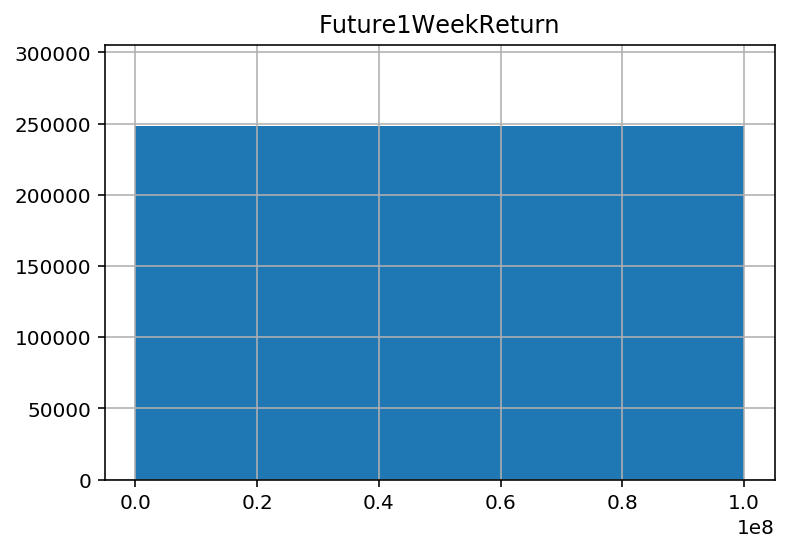

Instances:  771258
Mean:  0.9528324226271839
Min:  -99.92
25th percentile:  -4.166477525538371
Median:  0.0
75th percentile:  3.532008830022078
Max:  49900.0
Std deviation:  104.66549770977275
Variance:  10954.866410834444
Skew:  436.159213561
-----
Future2WeekReturn


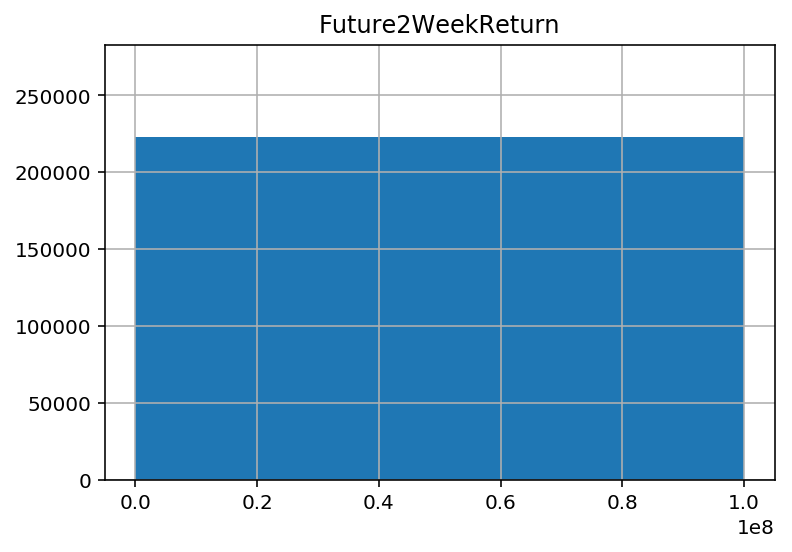

Instances:  768178
Mean:  1.5674015114507465
Min:  -99.96
25th percentile:  -6.245232613447025
Median:  0.0
75th percentile:  5.041693008332588
Max:  49900.0
Std deviation:  139.03169348008464
Variance:  19329.811791940214
Skew:  297.834554507
-----
Future4WeekReturn


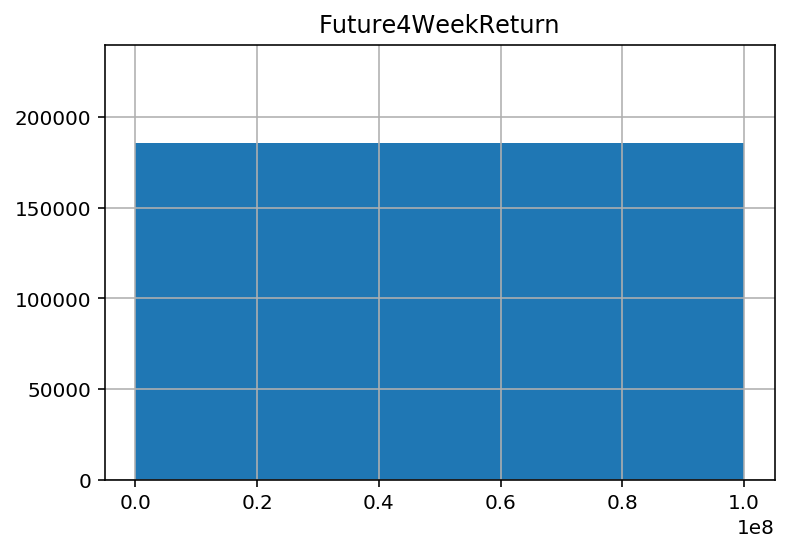

Instances:  763906
Mean:  4.1888037099139845
Min:  -99.96
25th percentile:  -9.22506201958628
Median:  0.0
75th percentile:  7.331410031814271
Max:  756799.988323
Std deviation:  1233.0148875735952
Variance:  1520325.7129781258
Skew:  605.800027354
-----
Future8WeekReturn


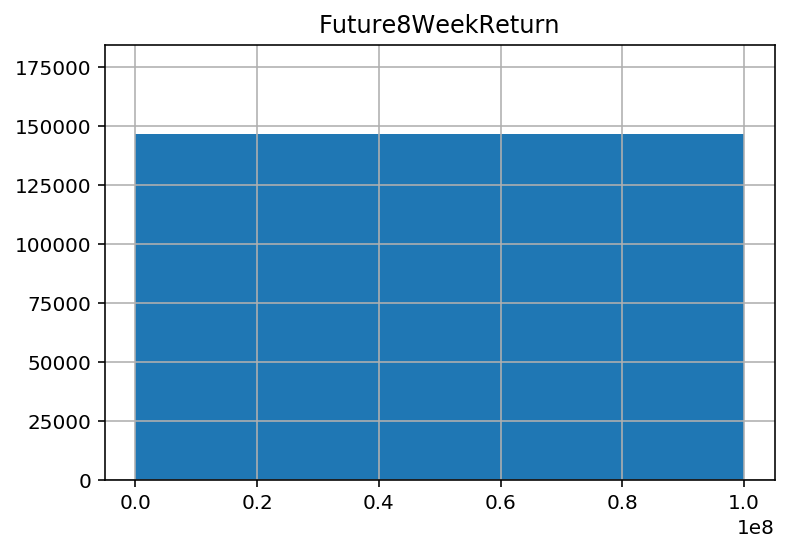

Instances:  756392
Mean:  10.807468561642954
Min:  -99.96
25th percentile:  -14.000238270449735
Median:  -0.3624301395888254
75th percentile:  10.684926885952233
Max:  756799.988323
Std deviation:  2347.7533138441677
Variance:  5511945.6226662705
Skew:  315.554453483
-----
Future12WeekReturn


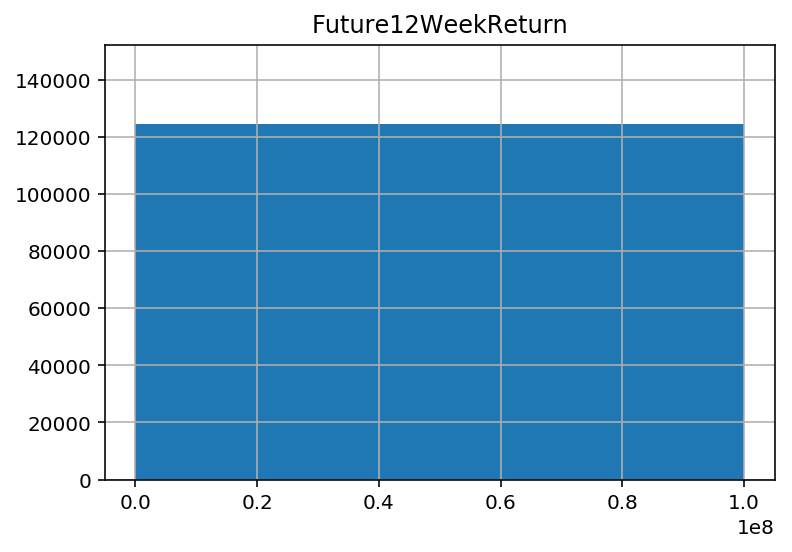

Instances:  747849
Mean:  5.044182765580537
Min:  -99.96
25th percentile:  -17.72727272727273
Median:  -0.9523809523809532
75th percentile:  13.380335005204895
Max:  756799.988323
Std deviation:  887.0880104726973
Variance:  786925.1383244083
Skew:  831.049346497
-----
Future26WeekReturn


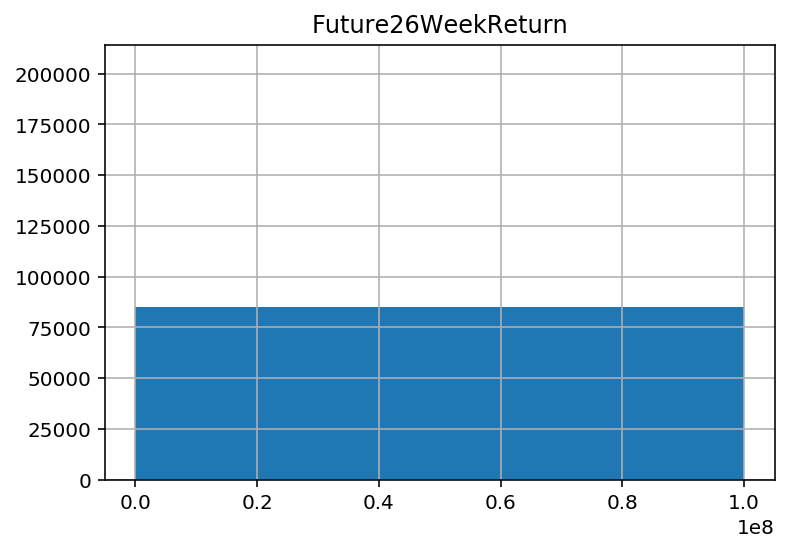

Instances:  719078
Mean:  14.013828354253457
Min:  -99.96
25th percentile:  -29.09090909090909
Median:  -3.124999999999991
75th percentile:  20.138132463997856
Max:  756799.988323
Std deviation:  2367.166778392296
Variance:  5603478.556724161
Skew:  318.149056804
-----
Future52WeekReturn


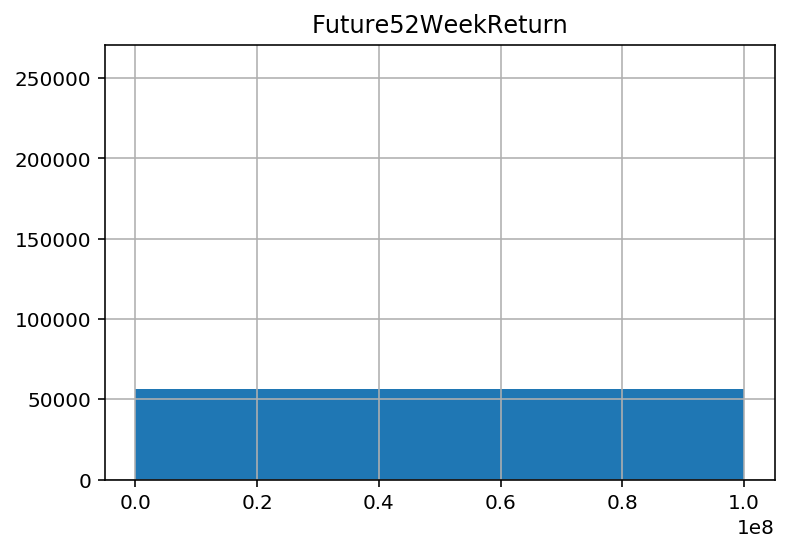

Instances:  673719
Mean:  14.879184180324275
Min:  -99.95
25th percentile:  -44.92753623188405
Median:  -7.6923076923076845
75th percentile:  29.25812356979406
Max:  756799.988323
Std deviation:  1407.3150161334056
Variance:  1980535.5546345678
Skew:  491.273662584
-----
Future1WeekRiskAdjustedReturn


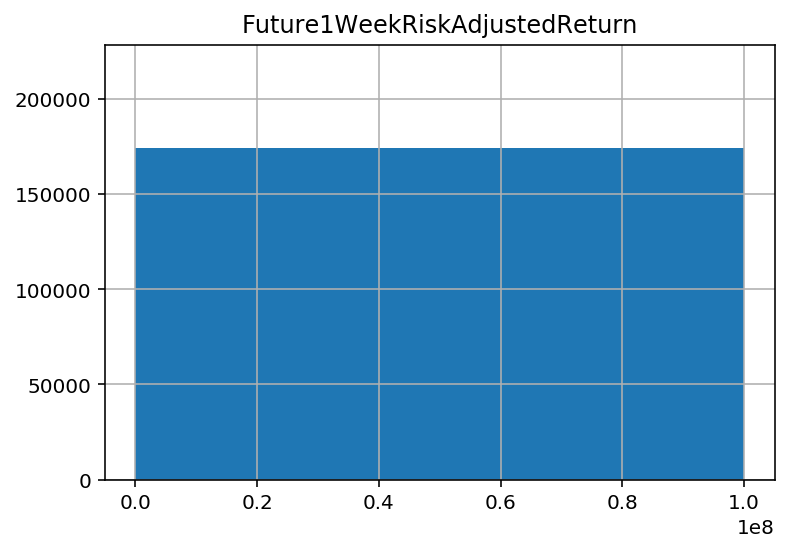

Instances:  771258
Mean:  -6.274343415501777
Min:  -99.0
25th percentile:  -6.832447236429337
Median:  0.0
75th percentile:  1.451068071072563
Max:  49900.0
Std deviation:  62.39024888382217
Variance:  3892.543155785273
Skew:  666.150042251
-----
Future2WeekRiskAdjustedReturn


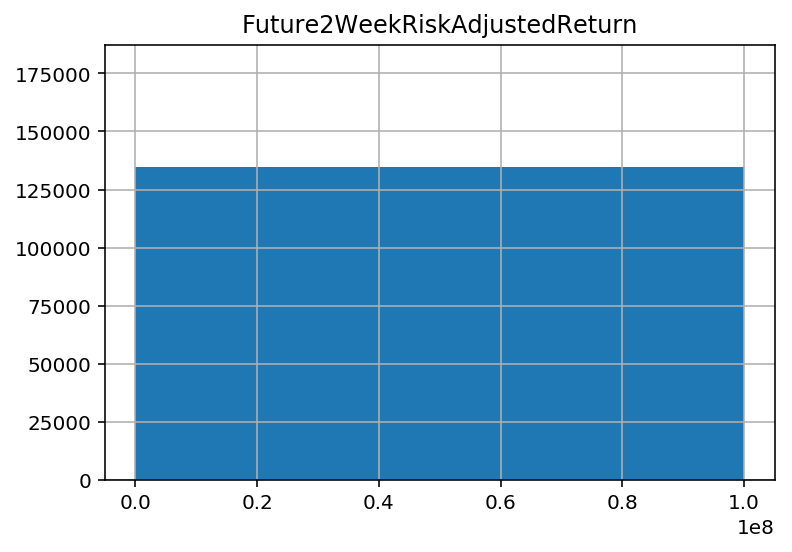

Instances:  768178
Mean:  -9.75533618963093
Min:  -99.0
25th percentile:  -11.538461538461537
Median:  0.0
75th percentile:  1.707451387294313
Max:  49900.0
Std deviation:  64.64408672473216
Variance:  4178.857948474693
Skew:  599.79695223
-----
Future4WeekRiskAdjustedReturn


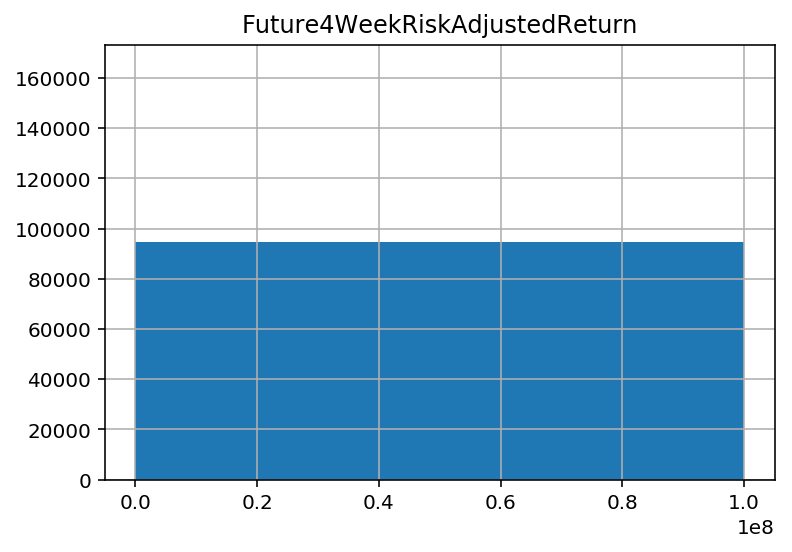

Instances:  763906
Mean:  -14.24482173580553
Min:  -99.0
25th percentile:  -20.0
Median:  0.0
75th percentile:  1.9156917902369668
Max:  49900.0
Std deviation:  67.8850803454045
Variance:  4608.384133502025
Skew:  520.724160024
-----
Future8WeekRiskAdjustedReturn


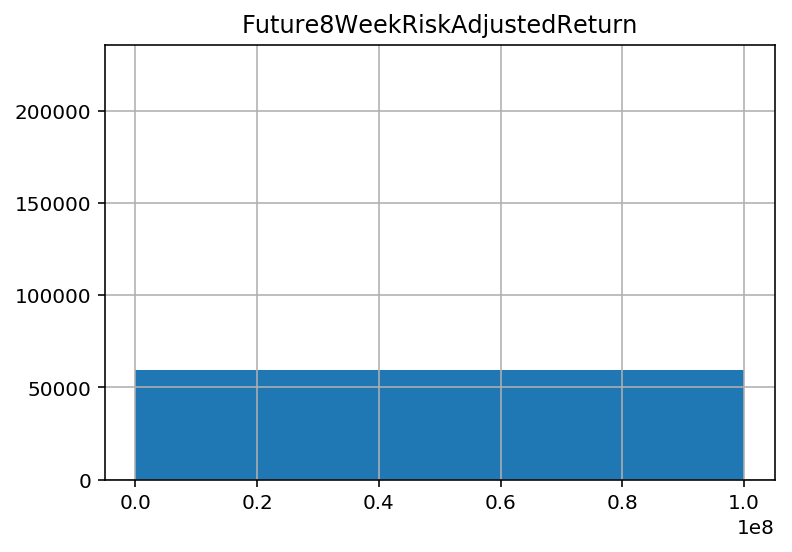

Instances:  756392
Mean:  -19.51659112687397
Min:  -99.0
25th percentile:  -34.436030290952566
Median:  -1.1325528539414425
75th percentile:  2.0855848055549266
Max:  6527.29912007
Std deviation:  44.17526612569554
Variance:  1951.4541372760243
Skew:  6.35537705473
-----
Future12WeekRiskAdjustedReturn


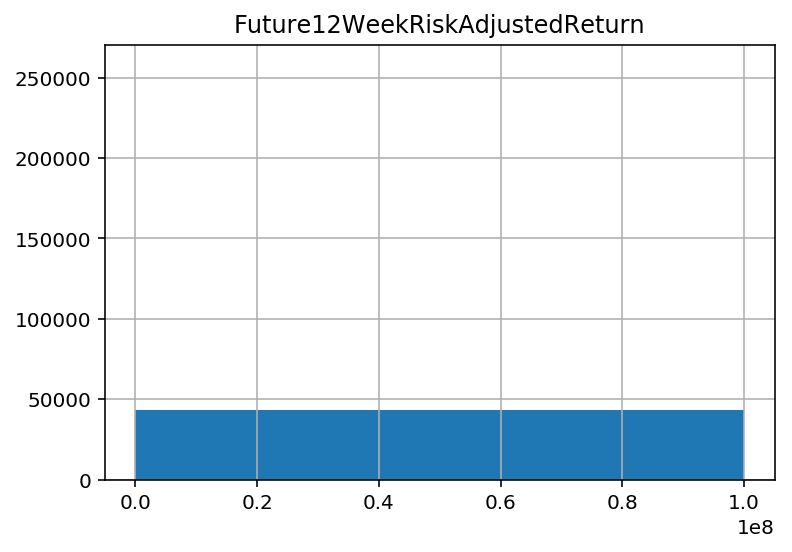

Instances:  747849
Mean:  -22.844035660149444
Min:  -99.0
25th percentile:  -49.71318323553252
Median:  -2.631578947368428
75th percentile:  2.1381167989637078
Max:  7650.60642153
Std deviation:  48.044307340535816
Variance:  2308.255467831864
Skew:  7.03849038674
-----
Future26WeekRiskAdjustedReturn


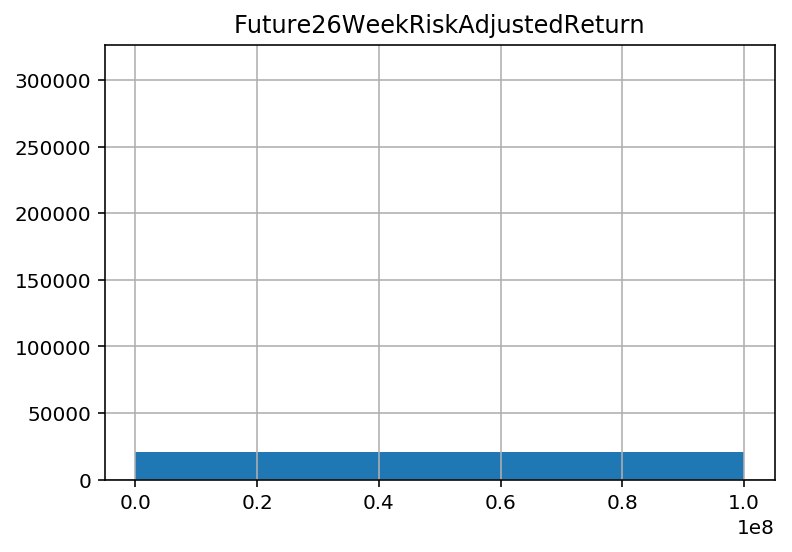

Instances:  719078
Mean:  -30.142244818964667
Min:  -99.0
25th percentile:  -99.0
Median:  -8.602150537634401
75th percentile:  2.117613272331397
Max:  5192.97417288
Std deviation:  56.0508192153567
Variance:  3141.6943347125994
Skew:  3.57091820714
-----
Future52WeekRiskAdjustedReturn


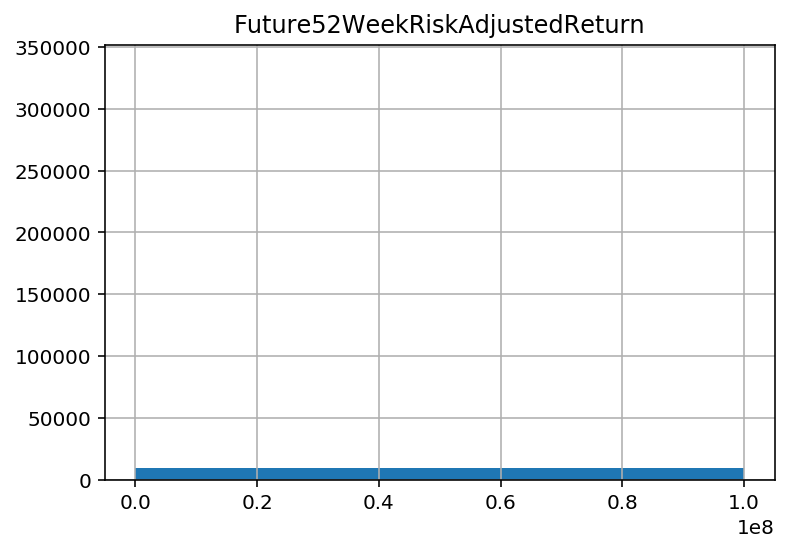

Instances:  673719
Mean:  -36.71186629331046
Min:  -99.0
25th percentile:  -99.0
Median:  -24.137507452679205
75th percentile:  1.8969033890460054
Max:  5400.0
Std deviation:  65.774760033103
Variance:  4326.319057412284
Skew:  7.40619074082


In [21]:
# Plot values for each potential target using bucket values
for key in returns:
    print('-----')
    return_column = returns[key]
    bins = buckets[key] 
    print(return_column)
    raw_data.hist(column=return_column,bins=bins)
    pyplot.show()


    print('Instances: ', raw_data[return_column].count())
    print('Mean: ', raw_data[return_column].mean())
    print('Min: ', raw_data[return_column].min())
    print('25th percentile: ', raw_data[return_column].quantile(0.25))
    print('Median: ', raw_data[return_column].median())
    print('75th percentile: ', raw_data[return_column].quantile(0.75))
    print('Max: ', raw_data[return_column].max())
    print('Std deviation: ', raw_data[return_column].std())
    print('Variance: ', raw_data[return_column].var())
    print('Skew: ', raw_data[return_column].skew())

## Set target column

In [27]:
# Set target column
# target_column = returns['8']

target_column = 'CatFuture12WeekReturn'

## Remove outliers

In [ ]:
# Check outliers
outliers = raw_data.loc[(raw_data[target_column] > 100) | (raw_data[target_column] < -50)]
print(len(outliers))

exclude_symbols = outliers['symbol'].unique()

In [ ]:
# Remove rows in the excluded symbols list
filtered_data = raw_data[~raw_data['symbol'].isin(exclude_symbols)]


In [ ]:
# Re-plot values for each potential target
for key in returns:
    print('-----')
    return_column = returns[key]
    print(return_column)
    filtered_data.hist(column=return_column,bins=[-50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0,
                                                  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    pyplot.show()


    print('Instances: ', filtered_data[return_column].count())
    print('Mean: ', filtered_data[return_column].mean())
    print('Min: ', filtered_data[return_column].min())
    print('25th percentile: ', filtered_data[return_column].quantile(0.25))
    print('Median: ', filtered_data[return_column].median())
    print('75th percentile: ', filtered_data[return_column].quantile(0.75))
    print('Max: ', filtered_data[return_column].max())
    print('Std deviation: ', filtered_data[return_column].std())
    print('Variance: ', filtered_data[return_column].var())
    print('Skew: ', filtered_data[return_column].skew())


## Remove missing values

In [28]:
# Remove rows missing the target column
filtered_data = filtered_data.dropna(subset=[target_column], how='all')

# Create y_data
base_y_data = filtered_data[target_column].values


# Filter down data to the X columns being used
filtered_data = filtered_data[data_columns]


print(filtered_data.dtypes)

print('Min:',min(y_data),', Max:', max(y_data))

symbol                                object
quoteDate                             object
adjustedPrice                        float64
volume                                 int64
previousClose                        float64
change                               float64
changeInPercent                      float64
52WeekHigh                           float64
52WeekLow                            float64
changeFrom52WeekHigh                 float64
changeFrom52WeekLow                  float64
percebtChangeFrom52WeekHigh          float64
percentChangeFrom52WeekLow           float64
Price200DayAverage                   float64
Price52WeekPercChange                float64
1WeekVolatility                      float64
2WeekVolatility                      float64
4WeekVolatility                      float64
8WeekVolatility                      float64
12WeekVolatility                     float64
26WeekVolatility                     float64
52WeekVolatility                     float64
4WeekBolli

## Convert non-numerical values

In [29]:
from datetime import datetime as dt
from dateutil.parser import parse

def is_date(string):
    try: 
        parse(string)
        return True
    except:
        return False

def convert_date_to_ordinal(date_val):
    if(pd.isnull(date_val)):
        return -99999
    
    elif(type(date_val) is str):
        if(is_date(date_val)):
            return parse(date_val).toordinal()
        else:
            return -99999

    elif(type(date_val) is int or type(date_val) is float):
        return date_val
    

# Fix date values - convert to ordinals
filtered_data['quoteDate'] = filtered_data['quoteDate'].apply(lambda x: convert_date_to_ordinal(x))

# print(filtered_data['exDividendDate'].apply(lambda x: convert_date_to_ordinal(x)))
filtered_data['exDividendDate'] = filtered_data['exDividendDate'].apply(lambda x: convert_date_to_ordinal(x))

print(filtered_data.head(5))

# Convert categorical variables to boolean fields
#  4WeekBollingerPrediction              
#  4WeekBollingerType                    
#  12WeekBollingerPrediction             
#  12WeekBollingerType                   

filtered_data = pd.get_dummies(data=filtered_data, columns=['symbol', '4WeekBollingerPrediction', '4WeekBollingerType', 
                                                            '12WeekBollingerPrediction', '12WeekBollingerType'])


# Fill nan values with placeholder and check for null values
filtered_data = filtered_data.fillna(-99999)
print(pd.isnull(filtered_data).any())

     symbol  quoteDate  adjustedPrice  volume  previousClose  change  \
3366    AOU     734381           0.25   49800          0.225   0.025   
3367    AOU     734382           0.30   30200          0.250   0.050   
3368    AOU     734385           0.26   12000          0.260   0.000   
3369    AOU     734388           0.26   16100          0.260   0.000   
3370    AOU     734389           0.25    6000          0.250   0.000   

      changeInPercent  52WeekHigh  52WeekLow  changeFrom52WeekHigh  \
3366         0.111111        0.25       0.25                  0.00   
3367         0.200000        0.30       0.25                  0.00   
3368         1.000000        0.30       0.25                 -0.04   
3369         1.000000        0.30       0.25                 -0.04   
3370         1.000000        0.30       0.25                 -0.05   

      changeFrom52WeekLow  percebtChangeFrom52WeekHigh  \
3366                 0.00                     0.000000   
3367                 0.05     

## Label Encoder

In [30]:
from sklearn import preprocessing

# Check data types
print(filtered_data.dtypes)

# Copy over X_data columns
X_data = filtered_data.values

le = preprocessing.LabelEncoder()
y_data = le.fit_transform(base_y_data)
print(list(le.classes_))

# View some sample records
print(X_data[range(0,5)])

# View some sample records
print(y_data[range(0,5)])


quoteDate                              int64
adjustedPrice                        float64
volume                                 int64
previousClose                        float64
change                               float64
changeInPercent                      float64
52WeekHigh                           float64
52WeekLow                            float64
changeFrom52WeekHigh                 float64
changeFrom52WeekLow                  float64
percebtChangeFrom52WeekHigh          float64
percentChangeFrom52WeekLow           float64
Price200DayAverage                   float64
Price52WeekPercChange                float64
1WeekVolatility                      float64
2WeekVolatility                      float64
4WeekVolatility                      float64
8WeekVolatility                      float64
12WeekVolatility                     float64
26WeekVolatility                     float64
52WeekVolatility                     float64
allordpreviousclose                  float64
allordchan

## One Hot Encoder

In [12]:
from sklearn import preprocessing
from keras.utils import np_utils

# Check data types
#print(filtered_data.dtypes)

# Copy over X_data columns
X_data = filtered_data.values


le = preprocessing.LabelEncoder()
y_numerical_data = le.fit_transform(base_y_data)
print(list(le.classes_))

print(y_numerical_data)

# y_data = np_utils.to_categorical(y_numerical_data)

y_data = y_numerical_data


# print(list(enc.feature_indices_))

# View some sample records
#print(X_data[range(0,5)])

# View some sample records
print(y_data)


Using TensorFlow backend.


['Average', 'Excellent', 'Good', 'Huge loss', 'Loss', 'Marginal', 'Off the charts gain', 'Poor', 'Risky gain', 'Serious loss']
[8 4 1 ..., 8 1 2]
[8 4 1 ..., 8 1 2]


## Run xgboost classifier - early stopping

In [12]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time

# Split into train and test data
print('Splitting data')
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

print('Training for', target_column)

# Fit model with training set
start = time.time()
model = xgb.XGBClassifier(nthread=-1, objective='multi:softmax', n_estimators=10000, max_depth=100,
                         learning_rate=0.15)
model.num_classes = 10
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="mlogloss", eval_set=eval_set, verbose=True)
# Output model settings
fit_time = time.time()
print(model)
print('Fit elapsed time: %d' % (fit_time - start))


# make predictions for test data
predictions = model.predict(X_test)
predition_time = time.time()
print('Prediction elapsed time: %d' % (predition_time - fit_time))
print(model)

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:', accuracy)

print(confusion_matrix(y_test, predictions))

# max_depth: 50 -> 0.73
# max_depth: 80 -> 0.73
# max_depth: 100 -> 0.75
# max_depth: 120 -> 0.73
# max_depth: 200 -> 0.74

#learning_rate: 0.01 -> 0.74
#learning_rate: 0.05 -> 0.71
#learning_rate: 0.1 -> 0.75


Splitting data
Training for CatFuture12WeekReturn
[0]	validation_0-mlogloss:1.98412
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.79
[2]	validation_0-mlogloss:1.64502
[3]	validation_0-mlogloss:1.52773
[4]	validation_0-mlogloss:1.43044
[5]	validation_0-mlogloss:1.35458
[6]	validation_0-mlogloss:1.29081
[7]	validation_0-mlogloss:1.23722
[8]	validation_0-mlogloss:1.18942
[9]	validation_0-mlogloss:1.14974
[10]	validation_0-mlogloss:1.11563
[11]	validation_0-mlogloss:1.0856
[12]	validation_0-mlogloss:1.06074
[13]	validation_0-mlogloss:1.0371
[14]	validation_0-mlogloss:1.01638
[15]	validation_0-mlogloss:0.997676
[16]	validation_0-mlogloss:0.980641
[17]	validation_0-mlogloss:0.967452
[18]	validation_0-mlogloss:0.955894
[19]	validation_0-mlogloss:0.945819
[20]	validation_0-mlogloss:0.936484
[21]	validation_0-mlogloss:0.92877
[22]	validation_0-mlogloss:0.921156
[23]	validation_0-mlogloss:0.915749
[24]	validation_0-mlogloss:0.910539
[25]	validat

## CVGridSearch with early stopping

In [13]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time

# Split into train and test data
print('Splitting data')
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

kfold = KFold(n_splits=4, shuffle=True)

print('Training for', target_column)

# Fit model with training set
start = time.time()
model = xgb.XGBClassifier(nthread=-1, objective='multi:softmax', n_estimators=10000, learning_rate=0.1, 
                          max_depth=40, gamma=0.1, min_child_weight=0.7, scale_pos_weight=0.7, 
                          colsample_bylevel=0.7, colsample_bytree=0.8, max_delta_step=0.25, 
                          subsample=0.9, reg_alpha=0.1, reg_lambda=0.95)
model.num_classes = 10
eval_set = [(X_test, y_test)]
over_fifty = [i/100.0 for i in range(70, 101, 5)]
under_fifty = [i/100.0 for i in range(0, 31, 5)]

paramGrid = {
            #"max_depth": [i for i in range(10, 101, 10)],
            #"learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]#,
            #"min_child_weight": over_fifty,
            #"gamma": under_fifty,
            #"scale_pos_weight": over_fifty#,
            #"colsample_bylevel": over_fifty,
            #"colsample_bytree": over_fifty#,
            #"subsample": over_fifty,
            #"max_delta_step": under_fifty#,
            "reg_lambda": over_fifty,
            "reg_alpha": under_fifty
            }

fit_params = {
            "early_stopping_rounds": 50, 
            "eval_metric": "mlogloss", 
            "eval_set": eval_set, 
            "verbose": False
            }

grid_search = GridSearchCV(model, paramGrid, fit_params=fit_params, verbose=2, cv=kfold)

grid_result = grid_search.fit(X_train, y_train)
# Output model settings
fit_time = time.time()
print('Fit elapsed time: %d' % (fit_time - start))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(model)

params = grid_result.cv_results_['params']


Splitting data
Training for CatFuture12WeekReturn
Fitting 4 folds for each of 49 candidates, totalling 196 fits
[CV] reg_alpha=0.0, reg_lambda=0.7 ...................................
[CV] .................... reg_alpha=0.0, reg_lambda=0.7, total=  16.1s
[CV] reg_alpha=0.0, reg_lambda=0.7 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.2s remaining:    0.0s


[CV] .................... reg_alpha=0.0, reg_lambda=0.7, total=  16.5s
[CV] reg_alpha=0.0, reg_lambda=0.7 ...................................
[CV] .................... reg_alpha=0.0, reg_lambda=0.7, total=  16.6s
[CV] reg_alpha=0.0, reg_lambda=0.7 ...................................
[CV] .................... reg_alpha=0.0, reg_lambda=0.7, total=  17.1s
[CV] reg_alpha=0.0, reg_lambda=0.75 ..................................
[CV] ................... reg_alpha=0.0, reg_lambda=0.75, total=  16.4s
[CV] reg_alpha=0.0, reg_lambda=0.75 ..................................
[CV] ................... reg_alpha=0.0, reg_lambda=0.75, total=  16.0s
[CV] reg_alpha=0.0, reg_lambda=0.75 ..................................
[CV] ................... reg_alpha=0.0, reg_lambda=0.75, total=  16.6s
[CV] reg_alpha=0.0, reg_lambda=0.75 ..................................
[CV] ................... reg_alpha=0.0, reg_lambda=0.75, total=  16.8s
[CV] reg_alpha=0.0, reg_lambda=0.8 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed: 68.4min finished


Fit elapsed time: 4129
Best: 0.720705 using {'reg_alpha': 0.1, 'reg_lambda': 0.95}
XGBClassifier(base_score=0.5, colsample_bylevel=0.7, colsample_bytree=0.8,
       gamma=0.1, learning_rate=0.1, max_delta_step=0.25, max_depth=40,
       min_child_weight=0.7, missing=None, n_estimators=10000, nthread=-1,
       objective='multi:softmax', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.7, seed=0, silent=True, subsample=0.9)


## Basic fit

In [ ]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time

# Split into train and test data
print('Splitting data')
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

print('Training for', target_column)


# Fit model with training set
start = time.time()
model = xgb.XGBClassifier(nthread=-1)
model.fit(X_train, y_train)
# Output model settings
fit_time = time.time()
print(model)
print('Fit elapsed time: %d' % (fit_time - start))


# make predictions for test data
predictions = model.predict(X_test)
predition_time = time.time()
print('Prediction elapsed time: %d' % (predition_time - fit_time))
print(model)

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:', accuracy)

print(confusion_matrix(y_test, predictions))


In [ ]:
print(le.classes_)
print(confusion_matrix(y_test, predictions))

## Optimise reduced symbol model

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Start with simple optimisation
from sklearn.metrics import mean_absolute_error
import time

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

if __name__ == "__main__":
    print("Work through parameter optimization")
    
    model = xgb.XGBClassifier(nthread=-1)

    kfold = KFold(n_splits=4, shuffle=True)


    print("Set non-optimised baseline")
    round_err = []
    for r in range(0, 3):
        err = []
        for train_index, test_index in kfold.split(X_data):
            model.fit(X_data[train_index],y_data[train_index])
            predictions = model.predict(X_data[test_index])
            actuals = y_data[test_index]
            err.append(accuracy_score(actuals, predictions))

        print(np.mean(err))
        round_err.append(np.mean(err))

    baseline_accuracy = np.mean(round_err)

    print("Average baseline accuracy: %f" % baseline_accuracy)
    print('-----')
    
#     n_estimators=[1000, 1500, 2000]
        
#     param_grid = dict(n_estimators=n_estimators)

#     grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=2, n_jobs=-1)
#     n_estimators_r = []

#     for r in range(0, 3):
#         grid_result = grid_search.fit(X_data, y_data)
#         # summarize results
#         print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#         n_estimators_r.append(grid_result.best_params_['n_estimators'])
#         means = grid_result.cv_results_['mean_test_score']
#         stds = grid_result.cv_results_['std_test_score']
#         params = grid_result.cv_results_['params']

#     n_estimators = find_nearest(n_estimators_r, np.mean(n_estimators_r))
    
#     model.n_estimators = n_estimators
    
#     print("Averaged best n_estimators: %f " % n_estimators)
#     print('-----')  

    model.n_estimators = 1500
    
    max_depth = [20, 30, 40, 50]
    param_grid = dict(max_depth=max_depth)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=2, n_jobs=-1)
    max_depths = []

    for r in range(0, 3):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        max_depths.append(grid_result.best_params_['max_depth'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    max_depth = find_nearest(max_depths, np.mean(max_depths))
    
    model.max_depth = max_depth
    
    print("Averaged best max depth: %f " % max_depth)
    print('-----')    
        
    learning_rate = [0.01, 0.05, 0.1, 0.15]
    param_grid = dict(learning_rate=learning_rate)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=2, n_jobs=-1)
    learning_rates = []

    for r in range(0, 3):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        learning_rates.append(grid_result.best_params_['learning_rate'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    learning_rate = find_nearest(learning_rates, np.mean(learning_rates))
    
    model.learning_rate = learning_rate
    
    print("Averaged best learning rate: %f " % learning_rate)
    print('-----')     


    samples = [0.6,0.8,1.0] #[i/100.0 for i in range(60,101, 5)]
    param_grid = dict(subsample=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=2, n_jobs=-1)
    subsamples = []

    for r in range(0, 3):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        subsamples.append(grid_result.best_params_['subsample'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    subsample = find_nearest(subsamples, np.mean(subsamples))
    
    model.subsample = subsample
    
    print("Averaged best subsample: %f " % subsample)
    print('-----')

    param_grid = dict(colsample_bytree=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=2, n_jobs=-1)
    colsample_bytrees = []

    for r in range(0, 3):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        colsample_bytrees.append(grid_result.best_params_['colsample_bytree'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    colsample_bytree = find_nearest(colsample_bytrees, np.mean(colsample_bytrees))
    
    model.colsample_bytree = colsample_bytree
    
    print("Averaged best colsample_bytree: %f " % colsample_bytree)
    print('-----')

    param_grid = dict(colsample_bylevel=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=2, n_jobs=-1)
    colsample_bylevels = []

    for r in range(0, 3):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        colsample_bylevels.append(grid_result.best_params_['colsample_bylevel'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    colsample_bylevel = find_nearest(colsample_bylevels, np.mean(colsample_bylevels))
    
    model.colsample_bylevel = colsample_bylevel
    
    print("Averaged best colsample_bylevel: %f " % colsample_bylevel)
    print('-----')

    # Retest with new parameters
    round_err = []
    for r in range(0, 3):
        for train_index, test_index in kfold.split(X_data):
            xgb_model = xgb.XGBClassifier(nthread=-1, colsample_bytree = colsample_bytree, 
                                         learning_rate = learning_rate, max_depth = max_depth, 
                                         n_estimators = n_estimators, subsample = subsample,
                                         colsample_bylevel = colsample_bylevel)
            xgb_model.fit(X_data[train_index],y_data[train_index])
            predictions = model.predict(X_data[test_index])
            actuals = y_data[test_index]
            err.append(accuracy_score(actuals, predictions))
               
        print(np.mean(err))
        round_err.append(np.mean(err))

    tuned_accuracy = np.mean(round_err)

    print("Average tuned accuracy: %s" % tuned_accuracy)
    improvement = tuned_accuracy - baseline_accuracy
    print('-----')
    print('Optimisation improvement result: %s, %s%%' % (improvement, improvement / baseline_accuracy * 100))
    print('-----')
    print(xgb_model)
    print('-----')

In [ ]:
from sklearn.metrics import mean_absolute_error
import time

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

if __name__ == "__main__":
    print("Work through parameter optimization")
    
    model = xgb.XGBClassifier(nthread=-1)

    kfold = KFold(n_splits=5, shuffle=True)


    print("Set non-optimised baseline")
    round_err = []
    for r in range(0, 5):
        err = []
        for train_index, test_index in kfold.split(X_data):
            model.fit(X_data[train_index],y_data[train_index])
            predictions = model.predict(X_data[test_index])
            actuals = y_data[test_index]
            err.append(accuracy_score(actuals, predictions))

        print(np.mean(err))
        round_err.append(np.mean(err))

    baseline_accuracy = np.mean(round_err)

    print("Average baseline accuracy: %f" % baseline_accuracy)
    print('-----')

    max_depth = [10, 30, 50]
    param_grid = dict(max_depth=max_depth)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    max_depths = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        max_depths.append(grid_result.best_params_['max_depth'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    max_depth = find_nearest(max_depths, np.mean(max_depths))
    
    model.max_depth = max_depth
    
    print("Averaged best max depth: %f " % max_depth)
    print('-----')    
    n_estimators=[500, 2500, 4500, 6500, 8500]
        
    param_grid = dict(n_estimators=n_estimators)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    n_estimators_r = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        n_estimators_r.append(grid_result.best_params_['n_estimators'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    n_estimators = find_nearest(n_estimators_r, np.mean(n_estimators_r))
    
    model.n_estimators = n_estimators
    
    print("Averaged best n_estimators: %f " % n_estimators)
    print('-----')  
        
    learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
    param_grid = dict(learning_rate=learning_rate)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    learning_rates = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        learning_rates.append(grid_result.best_params_['learning_rate'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    learning_rate = find_nearest(learning_rates, np.mean(learning_rates))
    
    model.learning_rate = learning_rate
    
    print("Averaged best learning rate: %f " % learning_rate)
    print('-----')     


    samples = [0.6,0.8,1.0] #[i/100.0 for i in range(60,101, 5)]
    param_grid = dict(subsample=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    subsamples = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        subsamples.append(grid_result.best_params_['subsample'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    subsample = find_nearest(subsamples, np.mean(subsamples))
    
    model.subsample = subsample
    
    print("Averaged best subsample: %f " % subsample)
    print('-----')

    param_grid = dict(colsample_bytree=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    colsample_bytrees = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        colsample_bytrees.append(grid_result.best_params_['colsample_bytree'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    colsample_bytree = find_nearest(colsample_bytrees, np.mean(colsample_bytrees))
    
    model.colsample_bytree = colsample_bytree
    
    print("Averaged best colsample_bytree: %f " % colsample_bytree)
    print('-----')

    param_grid = dict(colsample_bylevel=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    colsample_bylevels = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        colsample_bylevels.append(grid_result.best_params_['colsample_bylevel'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    colsample_bylevel = find_nearest(colsample_bylevels, np.mean(colsample_bylevels))
    
    model.colsample_bylevel = colsample_bylevel
    
    print("Averaged best colsample_bylevel: %f " % colsample_bylevel)
    print('-----')

    # Retest with new parameters
    round_err = []
    for r in range(0, 5):
        err = []
        for train_index, test_index in kfold.split(X_data):
            xgb_model = xgb.XGBClassifier(nthread=-1, colsample_bytree = colsample_bytree, 
                                         learning_rate = learning_rate, max_depth = max_depth, 
                                         n_estimators = n_estimators, subsample = subsample,
                                         colsample_bylevel = colsample_bylevel)
            xgb_model.fit(X_data[train_index],y_data[train_index])
            predictions = model.predict(X_data[test_index])
            actuals = y_data[test_index]
            err.append(accuracy_score(actuals, predictions))
               
        print(np.mean(err))
        round_err.append(np.mean(err))

    tuned_accuracy = np.mean(round_err)

    print("Average tuned accuracy: %s" % tuned_accuracy)
    improvement = tuned_accuracy - baseline_accuracy
    print('-----')
    print('Optimisation improvement result: %s, %s%%' % (improvement, improvement / baseline_accuracy * 100))
    print('-----')
    print(xgb_model)
    print('-----')

## Secondary parameters

In [ ]:
    weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    
#     gamma = [0]
#     param_grid = dict(gamma=gamma)

#     grid_search = GridSearchCV(model, param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
#     gammas = []

#     for r in range(0, 5):
#         grid_result = grid_search.fit(X_data, y_data)
#         # summarize results
#         print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#         gammas.append(grid_result.best_params_['gamma'])
#         means = grid_result.cv_results_['mean_test_score']
#         stds = grid_result.cv_results_['std_test_score']
#         params = grid_result.cv_results_['params']

#     gamma = find_nearest(gammas, np.mean(gammas))
    
#     model.gamma = gamma
    
#     print("Averaged best gamma: %f " % gamma)
#     print('-----')    
    
#     min_child_weight = [0]
#     param_grid = dict(min_child_weight=min_child_weight)

#     grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
#     min_child_weights = []

#     for r in range(0, 5):
#         grid_result = grid_search.fit(X_data, y_data)
#         # summarize results
#         print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#         min_child_weights.append(grid_result.best_params_['min_child_weight'])
#         means = grid_result.cv_results_['mean_test_score']
#         stds = grid_result.cv_results_['std_test_score']
#         params = grid_result.cv_results_['params']

#     min_child_weight = find_nearest(min_child_weights, np.mean(min_child_weights))
    
#     model.min_child_weight = min_child_weight
    
#     print("Averaged best min_child_weight: %f " % min_child_weight)
#     print('-----')

    gamma = 0
    min_child_weight = 0

    reg_lambda = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    param_grid = dict(reg_lambda=reg_lambda)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    reg_lambdas = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        reg_lambdas.append(grid_result.best_params_['reg_lambda'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    reg_lambda = find_nearest(reg_lambdas, np.mean(reg_lambdas))
    
    model.reg_lambda = reg_lambda
    
    print("Averaged best reg_lambda: %f " % reg_lambda)
    print('-----')

    scale_pos_weight = [0, 1, 2, 3, 4, 5]
    param_grid = dict(scale_pos_weight=scale_pos_weight)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    scale_pos_weights = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        scale_pos_weights.append(grid_result.best_params_['scale_pos_weight'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    scale_pos_weight = find_nearest(scale_pos_weights, np.mean(scale_pos_weights))
    
    model.scale_pos_weight = scale_pos_weight
    
    print("Averaged best scale_pos_weight: %f " % scale_pos_weight)
    print('-----')
    

    reg_alpha = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
    param_grid = dict(reg_alpha=reg_alpha)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    reg_alphas = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        reg_alphas.append(grid_result.best_params_['reg_alpha'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    reg_alpha = find_nearest(reg_alphas, np.mean(reg_alphas))
    
    model.reg_alpha = reg_alpha
    
    print("Averaged best reg_alpha: %f " % reg_alpha)
    print('-----')
        
    base_score = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
    param_grid = dict(base_score=base_score)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    base_scores = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        base_scores.append(grid_result.best_params_['base_score'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    base_score = find_nearest(base_scores, np.mean(base_scores))
    
    model.base_score = base_score
    
    print("Averaged best base_score: %f " % base_score)
    print('-----')

    
    # Retest with new parameters
    round_err = []
    for r in range(0, 5):
        err = []
        for train_index, test_index in kfold.split(X_data):
            xgb_model = xgb.XGBRegressor(nthread=-1, colsample_bytree = colsample_bytree, gamma=gamma, 
                                         learning_rate = learning_rate, max_depth = max_depth, 
                                         n_estimators = n_estimators, subsample = subsample,
                                         colsample_bylevel = colsample_bylevel, base_score = base_score,
                                         reg_alpha = reg_alpha, scale_pos_weight = scale_pos_weight,
                                         reg_lambda = reg_lambda, min_child_weight = min_child_weight)
            xgb_model.fit(X_data[train_index],y_data[train_index])
            predictions = model.predict(X_data[test_index])
            actuals = y_data[test_index]
            err.append(accuracy_score(actuals, predictions))
               
        print(np.mean(err))
        round_err.append(np.mean(err))

    tuned_error = np.mean(round_err)

    print("Average tuned error: %s" % tuned_error)
    improvement = baseline_error - tuned_error
    print('-----')
    print('Optimisation improvement result: %s, %s%%' % (improvement, improvement / baseline_error * 100))
    print('-----')
    print(xgb_model)
    print('-----')

In [ ]:
    model.max_depth = 70
    n_estimators=[7000, 7500, 8000, 8500, 9000, 9500, 10000]
        
    param_grid = dict(n_estimators=n_estimators)

    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", cv=kfold, verbose=1, n_jobs=-1)
    n_estimators_r = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        n_estimators_r.append(grid_result.best_params_['n_estimators'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    n_estimators = find_nearest(n_estimators_r, np.mean(n_estimators_r))
    
    model.n_estimators = n_estimators
    
    print("Averaged best n_estimators: %f " % n_estimators)
    print('-----')  

## Compare model to baseline (with early stopping)

In [31]:
import time


# Test with base parameters
print('-----')
print('Base model')

base_accuracies = []
for r in range(0, 5):
    print('Splitting data')
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)
    eval_set = [(X_test, y_test)]
    start = time.time()
    base_model = xgb.XGBClassifier(nthread=-1, objective='multi:softmax')
    base_model.num_classes = 10
    base_model.fit(X_train, y_train)
    fit_time = time.time()
    predictions = base_model.predict(X_test)
    prediction_time = time.time()
    actuals = y_test
    base_accuracies.append(accuracy_score(actuals, predictions))
    print(accuracy_score(actuals, predictions))
    print('Fit elapsed time: %d, Prediction elapsed time: %d' % (fit_time - start, prediction_time - fit_time))

base_accuracy = np.mean(base_accuracies)

print('-----')
print(base_model)
print("Average base accuracy: %s" % base_accuracy)


# Retest with new parameters
print('-----')
print('Optimised model')

opt_accuracies = []
for r in range(0, 5):
    print('Splitting data')
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)
    eval_set = [(X_test, y_test)]
    start = time.time()
    tuned_model = xgb.XGBClassifier(nthread=-1, objective='multi:softmax', n_estimators=10000, learning_rate=0.1, 
                          max_depth=40, gamma=0.1, min_child_weight=0.7, scale_pos_weight=0.7, 
                          colsample_bylevel=0.7, colsample_bytree=0.8, max_delta_step=0.25, 
                          subsample=0.9, reg_alpha=0.1, reg_lambda=0.95)
    tuned_model.num_classes = 10
    tuned_model.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="mlogloss", eval_set=eval_set, 
                    verbose=False)
    fit_time = time.time()
    predictions = tuned_model.predict(X_test)
    prediction_time = time.time()
    actuals = y_test
    opt_accuracies.append(accuracy_score(actuals, predictions))             
    print(accuracy_score(actuals, predictions))
    print('Fit elapsed time: %d, Prediction elapsed time: %d' % (fit_time - start, prediction_time - fit_time))

tuned_accuracy = np.mean(opt_accuracies)

print('-----')
print(tuned_model)
print("Average tuned accuracy: %s" % tuned_accuracy)
improvement =  tuned_accuracy - base_accuracy
print('-----')
print('Optimisation improvement result: %s, %s%%' % (improvement, improvement / base_accuracy * 100))
print('-----')



-----
Base model
Splitting data
0.643452380952
Fit elapsed time: 2, Prediction elapsed time: 0
Splitting data
0.630357142857
Fit elapsed time: 2, Prediction elapsed time: 0
Splitting data
0.617857142857
Fit elapsed time: 2, Prediction elapsed time: 0
Splitting data
0.62380952381
Fit elapsed time: 2, Prediction elapsed time: 0
Splitting data
0.644642857143
Fit elapsed time: 2, Prediction elapsed time: 0
-----
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Average base accuracy: 0.632023809524
-----
Optimised model
Splitting data
0.760714285714
Fit elapsed time: 24, Prediction elapsed time: 0
Splitting data
0.759523809524
Fit elapsed time: 20, Prediction elapsed time: 0
Splitting data
0.774404761905
Fit elaps

## Data checks

In [ ]:
# Check correlations 
filtered_data[data_columns].corr()
